In [1]:
%pip install pandas==2.1.1
%pip install scorecardpy==0.1.9.7
%pip install seaborn==0.13.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# For scorecard construction
import warnings
import scorecardpy as sc
import pprint

# Step 1: Data Exploration

In [238]:
#View Application Data

appData = pd.read_csv("IS453 Group Assignment - Application Data.csv")
appData.head()
appData.info(max_cols=200, show_counts=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 120 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [239]:
#View Bureau Data
bureauData = pd.read_csv("IS453 Group Assignment - Bureau Data.csv")
bureauData.head()
bureauData.info(max_cols=200, show_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


## Variable selection and filtering

In [240]:
# for application data
print("="*80)
print("VARIABLE SELECTION AND FILTERING FOR APPLICATION DATA")
print("="*80)

# Initialize appData_filtered (copy of appData) before Step 0
appData_filtered = appData.copy()
cols_before = len(appData_filtered.columns)

# Step 0: Feature Engineering - Create aggregated features before filtering
print("\n0. FEATURE ENGINEERING - CREATING AGGREGATED FEATURES:")
print("-" * 80)

# Sum credit bureau inquiry columns into a single feature
# These columns represent mutually exclusive time windows, so summing gives total inquiries in past year
credit_bureau_cols = [
    'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR'
]

# Check which columns exist
existing_credit_bureau_cols = [col for col in credit_bureau_cols if col in appData_filtered.columns]

if len(existing_credit_bureau_cols) > 0:
    # Create summed feature (total inquiries in past year)
    appData_filtered['TOTAL_CREDIT_BUREAU_INQUIRIES_YEAR'] = 0
    for col in existing_credit_bureau_cols:
        appData_filtered['TOTAL_CREDIT_BUREAU_INQUIRIES_YEAR'] += appData_filtered[col].fillna(0)
    
    print(f"  ✓ Created feature: TOTAL_CREDIT_BUREAU_INQUIRIES_YEAR")
    print(f"    (Total credit bureau inquiries in the past year)")
   
    # Drop individual columns (they're now redundant)
    appData_filtered = appData_filtered.drop(columns=existing_credit_bureau_cols)
    print(f"  ✓ Dropped {len(existing_credit_bureau_cols)} individual credit bureau inquiry columns")
    print(f"    Dropped columns: {', '.join(existing_credit_bureau_cols)}")
    
    # Verify columns were actually dropped
    remaining_cols = [col for col in existing_credit_bureau_cols if col in appData_filtered.columns]
    if remaining_cols:
        print(f"  ⚠ Warning: Some columns were not dropped: {', '.join(remaining_cols)}")
    else:
        print(f"  ✓ Verified: All individual credit bureau columns successfully dropped")
else:
    print("  ⚠ No credit bureau inquiry columns found. Skipping feature engineering.")

# Step 1: Remove variables with only 1 unique value (categorical AND numeric)
print("\n1. DROPPING VARIABLES WITH NO VARIATION (1 unique value):")
print("-" * 80)

# NOTE: Binary columns (2 unique values like 0/1, Y/N) are SAFE - they won't be dropped
# Only columns with exactly 1 unique value will be dropped
single_value_cols = []
for col in appData_filtered.columns:
    if col in ['TARGET', 'SK_ID_CURR']:  # Skip ID and target columns
        continue
    
    # Only drop if column has exactly 1 unique value
    if appData_filtered[col].nunique(dropna=False) == 1:  # Check including NaN
        single_value_cols.append(col)
        unique_val = appData_filtered[col].dropna().unique()[0] if appData_filtered[col].dropna().nunique() > 0 else "all NaN"
        print(f"  Dropping: {col} (only 1 unique value: {unique_val})")

appData_filtered = appData_filtered.drop(columns=single_value_cols)
print(f"  Columns dropped: {len(single_value_cols)}")
print(f"  Remaining columns: {len(appData_filtered.columns)}")


# Step 2: Drop variables with more than 55% missing data
print("\n2. DROPPING VARIABLES WITH >55% MISSING DATA:")
print("-" * 80)

total_rows = len(appData_filtered)
missing_threshold = 0.55

high_missing_cols = []
for col in appData_filtered.columns:
    missing_count = appData_filtered[col].isnull().sum()
    missing_pct = missing_count / total_rows
    
    if missing_pct > missing_threshold:
        high_missing_cols.append(col)
        print(f"  Dropping: {col} ({missing_pct*100:.2f}% missing - {missing_count:,} out of {total_rows:,})")

appData_filtered = appData_filtered.drop(columns=high_missing_cols)
print(f"  Columns dropped: {len(high_missing_cols)}")
print(f"  Remaining columns: {len(appData_filtered.columns)}")

# Step 3: Drop variables with no variation between Goods and Bads
print("\n3. DROPPING VARIABLES WITH NO VARIATION BETWEEN GOODS AND BADS:")
print("-" * 80)

no_variation_cols = []
for col in appData_filtered.columns:
    if col == 'TARGET' or col == 'SK_ID_CURR':
        continue
    
    # Skip if column only has NaN values
    if appData_filtered[col].isnull().all():
        continue
    
    try:
        goods = appData_filtered[appData_filtered['TARGET'] == 0][col].dropna()
        bads = appData_filtered[appData_filtered['TARGET'] == 1][col].dropna()
        
        # Skip if either group has no data
        if len(goods) == 0 or len(bads) == 0:
            continue
        
        # For categorical variables: compare normalized distributions
        if appData_filtered[col].dtype == 'object' or appData_filtered[col].dtype.name == 'category':
            goods_dist = goods.value_counts(normalize=True)
            bads_dist = bads.value_counts(normalize=True)
            
            # Get union of all categories
            all_categories = goods_dist.index.union(bads_dist.index)
            
            # Reindex both distributions to have same categories, fill missing with 0
            goods_dist_aligned = goods_dist.reindex(all_categories, fill_value=0)
            bads_dist_aligned = bads_dist.reindex(all_categories, fill_value=0)
            
            # Check if distributions are identical (within small tolerance)
            if goods_dist_aligned.equals(bads_dist_aligned):
                no_variation_cols.append(col)
                print(f"  Dropping: {col} (identical distribution for goods and bads)")
        
        # For numeric variables: check if means are very similar and std devs are similar
        else:
            # Special handling for binary variables (variables with only 2 unique values)
            unique_values = pd.concat([goods, bads]).unique()
            if len(unique_values) == 2:
                # For binary variables, compare proportions of each value
                goods_prop_0 = (goods == unique_values[0]).sum() / len(goods) if len(goods) > 0 else 0
                goods_prop_1 = (goods == unique_values[1]).sum() / len(goods) if len(goods) > 0 else 0
                bads_prop_0 = (bads == unique_values[0]).sum() / len(bads) if len(bads) > 0 else 0
                bads_prop_1 = (bads == unique_values[1]).sum() / len(bads) if len(bads) > 0 else 0
                
                # Check if proportions are very similar (within 1% difference)
                prop_diff_0 = abs(goods_prop_0 - bads_prop_0) * 100
                prop_diff_1 = abs(goods_prop_1 - bads_prop_1) * 100
                
                # If proportions are very similar (within 1% difference), drop
                if prop_diff_0 < 1.0 and prop_diff_1 < 1.0:
                    no_variation_cols.append(col)
                    print(f"  Dropping: {col} (binary variable with almost identical proportions: goods={goods_prop_1:.2%}, bads={bads_prop_1:.2%})")
            else:
                # For non-binary numeric variables, check means and stds
                goods_mean = goods.mean()
                bads_mean = bads.mean()
                goods_std = goods.std()
                bads_std = bads.std()
                
                # If both means and stds are very close, consider dropping
                # Use relative difference threshold (1% for mean, 5% for std)
                mean_diff_pct = abs(goods_mean - bads_mean) / (abs(goods_mean) + 1e-10) * 100
                std_diff_pct = abs(goods_std - bads_std) / (abs(goods_std) + 1e-10) * 100 if goods_std > 0 else 0
                
                # Also check if both have very low variance (constant-like)
                if (mean_diff_pct < 1.0 and std_diff_pct < 5.0) or (goods_std < 1e-6 and bads_std < 1e-6):
                    no_variation_cols.append(col)
                    print(f"  Dropping: {col} (no meaningful difference between goods and bads)")
    
    except Exception as e:
        # Skip columns that cause errors
        pass

appData_filtered = appData_filtered.drop(columns=no_variation_cols)
print(f"  Columns dropped: {len(no_variation_cols)}")
print(f"  Remaining columns: {len(appData_filtered.columns)}")

# Step 4: Drop gender for fairness
print("\n4. DROPPING GENDER FOR FAIRNESS:")
print("-" * 80)

gender_cols = [col for col in appData_filtered.columns if 'GENDER' in col.upper()]
if gender_cols:
    for col in gender_cols:
        print(f"  Dropping: {col}")
    appData_filtered = appData_filtered.drop(columns=gender_cols)
else:
    print("  No gender columns found")

print(f"  Remaining columns: {len(appData_filtered.columns)}")

# Step 5: Drop columns based on business logic (Skill-Up Loans Context)
print("\n5. DROPPING COLUMNS BASED ON BUSINESS LOGIC (SKILL-UP LOANS):")
print("-" * 80)
print("Note: Dropping columns not relevant for skill-up loans (education/training loans)")
print("      These include housing/building info, redundant contact flags, etc.")

# Define columns to drop based on business logic
business_logic_cols = []

# 1. Contact/Phone flags - redundant 
contact_flags = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 
                 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL']
for col in contact_flags:
    if col in appData_filtered.columns:
        business_logic_cols.append(col)
        print(f"  Dropping: {col} (redundant contact flag)")

# 2. OWN_CAR_AGE - redundant
if 'OWN_CAR_AGE' in appData_filtered.columns:
    business_logic_cols.append('OWN_CAR_AGE')
    print(f"  Dropping: OWN_CAR_AGE (redundant)")

# 3. Social circle columns - redundant
social_circle_cols = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                      'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']
for col in social_circle_cols:
    if col in appData_filtered.columns:
        business_logic_cols.append(col)
        print(f"  Dropping: {col} (not relevant for skill-up loans)")

# 4. DAYS_LAST_PHONE_CHANGE - redundant
if 'DAYS_LAST_PHONE_CHANGE' in appData_filtered.columns:
    business_logic_cols.append('DAYS_LAST_PHONE_CHANGE')
    print(f"  Dropping: DAYS_LAST_PHONE_CHANGE (redundant)")

# 5. Housing/Building-related columns - NOT RELEVANT FOR SKILL-UP LOANS
housing_base_features = [
    'APARTMENTS', 'BASEMENTAREA', 'YEARS_BEGINEXPLUATATION', 'YEARS_BUILD',
    'COMMONAREA', 'ELEVATORS', 'ENTRANCES', 'FLOORSMAX', 'FLOORSMIN',
    'LANDAREA', 'LIVINGAPARTMENTS', 'LIVINGAREA', 'NONLIVINGAPARTMENTS',
    'NONLIVINGAREA', 'TOTALAREA', 'FONDKAPREMONT', 'HOUSETYPE',
    'WALLSMATERIAL', 'EMERGENCYSTATE'
]

# Drop all housing-related columns (_AVG, _MODE, _MEDI)
for base in housing_base_features:
    for suffix in ['_AVG', '_MODE', '_MEDI']:
        col = f"{base}{suffix}"
        if col in appData_filtered.columns and col not in business_logic_cols:
            business_logic_cols.append(col)
            print(f"  Dropping: {col} (housing/building info - not relevant for skill-up loans)")

# 6. Additional columns - not relevant for skill-up loans
# Asset ownership and demographic indicators
additional_cols_to_drop = [
    # Asset ownership flags
    'FLAG_OWN_CAR',  # Flag if client owns a car
    'FLAG_OWN_REALTY',  # Flag if client owns a house or flat
    # Demographic indicators
    'CNT_CHILDREN',  # Number of children
    'CNT_FAM_MEMBERS',  # Number of family members
    # Regional ratings
    'REGION_RATING_CLIENT',  # Rating of region where client lives
    'REGION_RATING_CLIENT_W_CITY',  # Rating of region with city taken into account
    # Behavioral indicators
    'WEEKDAY_APPR_PROCESS_START',  # Day of week client applied
    'HOUR_APPR_PROCESS_START',  # Hour client applied
    # Address mismatch flags
    'REG_REGION_NOT_LIVE_REGION',  # Permanent vs contact address mismatch (region)
    'REG_REGION_NOT_WORK_REGION',  # Permanent vs work address mismatch (region)
    'LIVE_REGION_NOT_WORK_REGION',  # Contact vs work address mismatch (region)
    'REG_CITY_NOT_LIVE_CITY',  # Permanent vs contact address mismatch (city)
    'REG_CITY_NOT_WORK_CITY',  # Permanent vs work address mismatch (city)
    'LIVE_CITY_NOT_WORK_CITY',  # Contact vs work address mismatch (city)
]

for col in additional_cols_to_drop:
    if col in appData_filtered.columns and col not in business_logic_cols:
        business_logic_cols.append(col)
        print(f"  Dropping: {col} (not relevant for skill-up loans)")

# 7. Family/Housing/Regional columns - not relevant for skill-up loans
# These columns describe family status, housing situation, and regional population
# which are not directly relevant for skill-up loans (education/training loans)
family_housing_cols = [
    'NAME_FAMILY_STATUS',  # Family status of the client
    'NAME_HOUSING_TYPE',  # Housing situation (renting, living with parents, etc.)
    'REGION_POPULATION_RELATIVE',  # Normalized population of region
    'NAME_TYPE_SUITE',  # Who was accompanying client when applying for loan
]

for col in family_housing_cols:
    if col in appData_filtered.columns and col not in business_logic_cols:
        business_logic_cols.append(col)
        print(f"  Dropping: {col} (family/housing/regional info - not relevant for skill-up loans)")

# 8. Employment-related columns - as customers may be seeking loans to change careers or re-enter workforce
if 'DAYS_EMPLOYED' in appData_filtered.columns and 'DAYS_EMPLOYED' not in business_logic_cols:
    business_logic_cols.append('DAYS_EMPLOYED')
    print(f"  Dropping: DAYS_EMPLOYED (employment duration - not relevant for skill-up loans)")

# Drop all identified columns
if business_logic_cols:
    appData_filtered = appData_filtered.drop(columns=business_logic_cols)
    print(f"\n  Columns dropped: {len(business_logic_cols)}")
    print(f"  Remaining columns: {len(appData_filtered.columns)}")
else:
    print("  No columns identified for business logic removal")

# Step 6: Filter rows based on age (25-55 years), income (<8000/month), contract type (Cash loans), and income type
print("\n6. FILTERING ROWS BY AGE, INCOME, CONTRACT TYPE, AND INCOME TYPE:")
print("-" * 80)

rows_before = len(appData_filtered)

# Age filtering: 25-55 years inclusive
# DAYS_BIRTH is negative (days before application date)
# Age 25 = -25 * 365 = -9125 days
# Age 55 = -55 * 365 = -20075 days
# Since DAYS_BIRTH is negative, we need: -20075 <= DAYS_BIRTH <= -9125

age_filter_applied = False
if 'DAYS_BIRTH' in appData_filtered.columns:
    # Calculate age boundaries
    age_min = 25
    age_max = 55
    days_birth_min = -age_max * 365  # More negative = older
    days_birth_max = -age_min * 365  # Less negative = younger
    
    # Filter rows where age is between 25-55 inclusive
    appData_filtered = appData_filtered[
        (appData_filtered['DAYS_BIRTH'] <= days_birth_max) & 
        (appData_filtered['DAYS_BIRTH'] >= days_birth_min)
    ]
    age_filter_applied = True
    print(f"  ✓ Age filter: {age_min}-{age_max} years (inclusive)")
    print(f"    DAYS_BIRTH range: {days_birth_min:.0f} to {days_birth_max:.0f} days")
else:
    print("  ⚠ Age filter: DAYS_BIRTH column not found. Skipping age filtering.")

# Income filtering: Monthly income < 8000 per month
# AMT_INCOME_TOTAL is annual income, so 8000/month = 96,000/year
income_filter_applied = False
if 'AMT_INCOME_TOTAL' in appData_filtered.columns:
    monthly_income_max = 8000
    annual_income_max = monthly_income_max * 12  # Convert to annual income
    
    # Filter rows where annual income < 96,000 (monthly < 8,000)
    appData_filtered = appData_filtered[
        appData_filtered['AMT_INCOME_TOTAL'] < annual_income_max
    ]
    income_filter_applied = True
    print(f"  ✓ Income filter: Monthly income < {monthly_income_max:,} per month")
    print(f"    Annual income < {annual_income_max:,} per year")
else:
    print("  ⚠ Income filter: AMT_INCOME_TOTAL column not found. Skipping income filtering.")

# Contract type filtering: Only keep 'Cash loans'
contract_type_filter_applied = False
if 'NAME_CONTRACT_TYPE' in appData_filtered.columns:
    contract_type = 'Cash loans'
    
    # Filter rows where NAME_CONTRACT_TYPE = 'Cash loans'
    appData_filtered = appData_filtered[
        appData_filtered['NAME_CONTRACT_TYPE'] == contract_type
    ]
    contract_type_filter_applied = True
    print(f"  ✓ Contract type filter: Only keeping '{contract_type}'")
else:
    print("  ⚠ Contract type filter: NAME_CONTRACT_TYPE column not found. Skipping contract type filtering.")

# Income type filtering: Only keep relevant income types for upskilling loans
income_type_filter_applied = False
if 'NAME_INCOME_TYPE' in appData_filtered.columns:
    # Keep only income types relevant for upskilling loans
    valid_income_types = [
        'Unemployed',
        'Working',
        'Commercial associate',  
        'State servant',  
        'Maternity leave'
    ]
    
    # Filter rows where NAME_INCOME_TYPE is in the valid list
    appData_filtered = appData_filtered[
        appData_filtered['NAME_INCOME_TYPE'].isin(valid_income_types)
    ]
    income_type_filter_applied = True
    print(f"  ✓ Income type filter: Only keeping {len(valid_income_types)} income types:")
    for income_type in valid_income_types:
        print(f"    - {income_type}")
else:
    print("  ⚠ Income type filter: NAME_INCOME_TYPE column not found. Skipping income type filtering.")

# Summary
rows_after = len(appData_filtered)
rows_dropped = rows_before - rows_after

print(f"\n  Rows before filtering: {rows_before:,}")
print(f"  Rows after filtering: {rows_after:,}")
print(f"  Rows dropped: {rows_dropped:,} ({rows_dropped/rows_before*100:.2f}%)")
print(f"  Remaining columns: {len(appData_filtered.columns)}")

# Final Summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nOriginal columns: {cols_before}")
print(f"Final columns: {len(appData_filtered.columns)}")
print(f"Columns dropped: {cols_before - len(appData_filtered.columns)}")

print(f"\nDropdown breakdown:")
print(f"  - ID columns (identified): {len(id_cols)} (not dropped, kept for reference)")
print(f"  - Single value (all types): {len(single_value_cols)}")
print(f"  - Duplicate columns: {len(duplicate_cols)}")
print(f"  - More than 55% missing data: {len(high_missing_cols)}")
print(f"  - No variation (goods vs bads): {len(no_variation_cols)}")
print(f"  - Gender (fairness): {len(gender_cols)}")
print(f"  - Business logic: {len(business_logic_cols)}")

# Add row filtering summary
print(f"\nRow filtering breakdown:")
print(f"  - Age filtering (25-55 years): {'Applied' if age_filter_applied else 'Not applied (DAYS_BIRTH column not found)'}")
print(f"  - Income filtering (<8000/month): {'Applied' if income_filter_applied else 'Not applied (AMT_INCOME_TOTAL column not found)'}")
print(f"  - Contract type filtering (Cash loans): {'Applied' if contract_type_filter_applied else 'Not applied (NAME_CONTRACT_TYPE column not found)'}")
print(f"  - Income type filtering (Unemployed, Working, etc.): {'Applied' if income_type_filter_applied else 'Not applied (NAME_INCOME_TYPE column not found)'}")
print(f"  (See Step 6 for detailed row counts)")

print(f"\nVariable name: appData_filtered")
print(f"Shape: {appData_filtered.shape}")

VARIABLE SELECTION AND FILTERING FOR APPLICATION DATA

0. FEATURE ENGINEERING - CREATING AGGREGATED FEATURES:
--------------------------------------------------------------------------------
  ✓ Created feature: TOTAL_CREDIT_BUREAU_INQUIRIES_YEAR
    (Total credit bureau inquiries in the past year)
  ✓ Dropped 6 individual credit bureau inquiry columns
    Dropped columns: AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR
  ✓ Verified: All individual credit bureau columns successfully dropped

1. DROPPING VARIABLES WITH NO VARIATION (1 unique value):
--------------------------------------------------------------------------------
  Columns dropped: 0
  Remaining columns: 115

2. DROPPING VARIABLES WITH >55% MISSING DATA:
--------------------------------------------------------------------------------
  Dropping: OWN_CAR_AGE (65.99% missing - 202,929 out of 307,511)
  Droppi

DISTRIBUTION ANALYSIS AND OUTLIER DETECTION - APPLICATION DATA

Analyzing 10 numeric features...

--------------------------------------------------------------------------------
OUTLIER DETECTION USING Z-SCORE (|z| > 3):
--------------------------------------------------------------------------------

Found outliers in 8 columns:
                            Column  Outliers  Percentage  Max Z-Score  Min Value  Max Value          Mean           Std
                   FLAG_DOCUMENT_3      2072    6.656600     3.744627        0.0        1.0      0.933434      0.249273
                   AMT_GOODS_PRICE       605    1.943650     7.489344    45000.0  2250000.0 369054.855559 251149.512929
TOTAL_CREDIT_BUREAU_INQUIRIES_YEAR       508    1.632024     9.660844        0.0       21.0      1.779227      1.989554
                        AMT_CREDIT       429    1.378225     7.537647    45000.0  2517300.0 419227.193899 278345.864573
                       AMT_ANNUITY       311    0.999165     6.5395

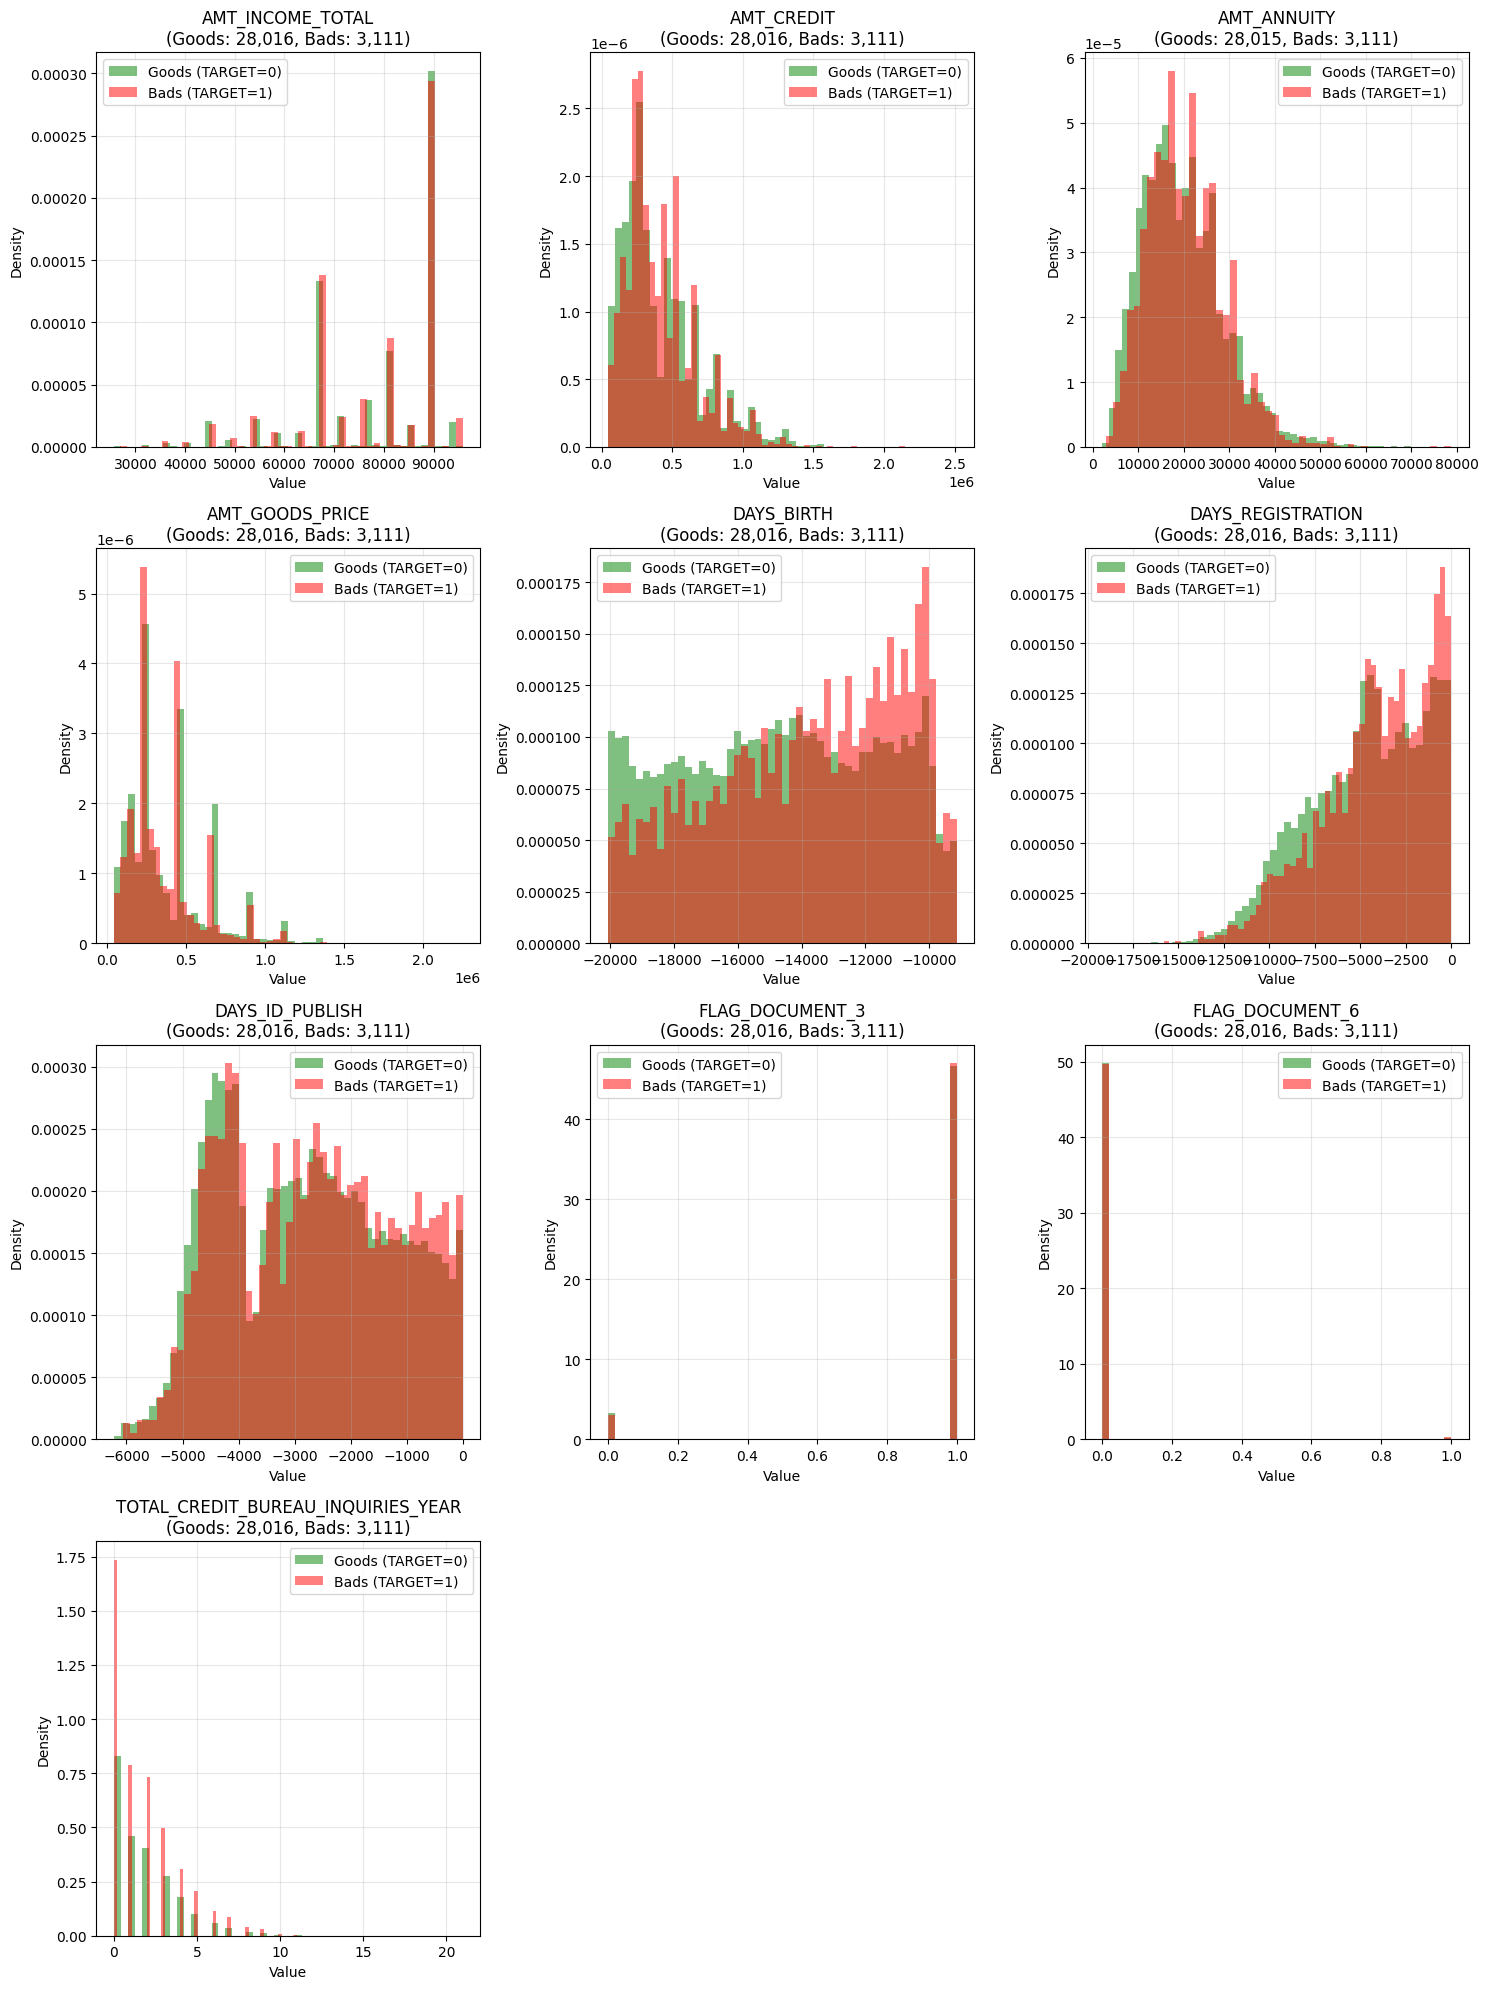


Plotted histograms for 10 key features (showing goods vs bads)

--------------------------------------------------------------------------------
BOXPLOT PLOTS - KEY NUMERIC FEATURES:
--------------------------------------------------------------------------------


/var/folders/wr/yrbny12n0vxf_hr5g_xl8tl00000gn/T/ipykernel_38487/3030250215.py:129: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/var/folders/wr/yrbny12n0vxf_hr5g_xl8tl00000gn/T/ipykernel_38487/3030250215.py:129: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/var/folders/wr/yrbny12n0vxf_hr5g_xl8tl00000gn/T/ipykernel_38487/3030250215.py:129: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/var/folders/wr/yrbny12n0vxf_hr5g_xl8tl0000

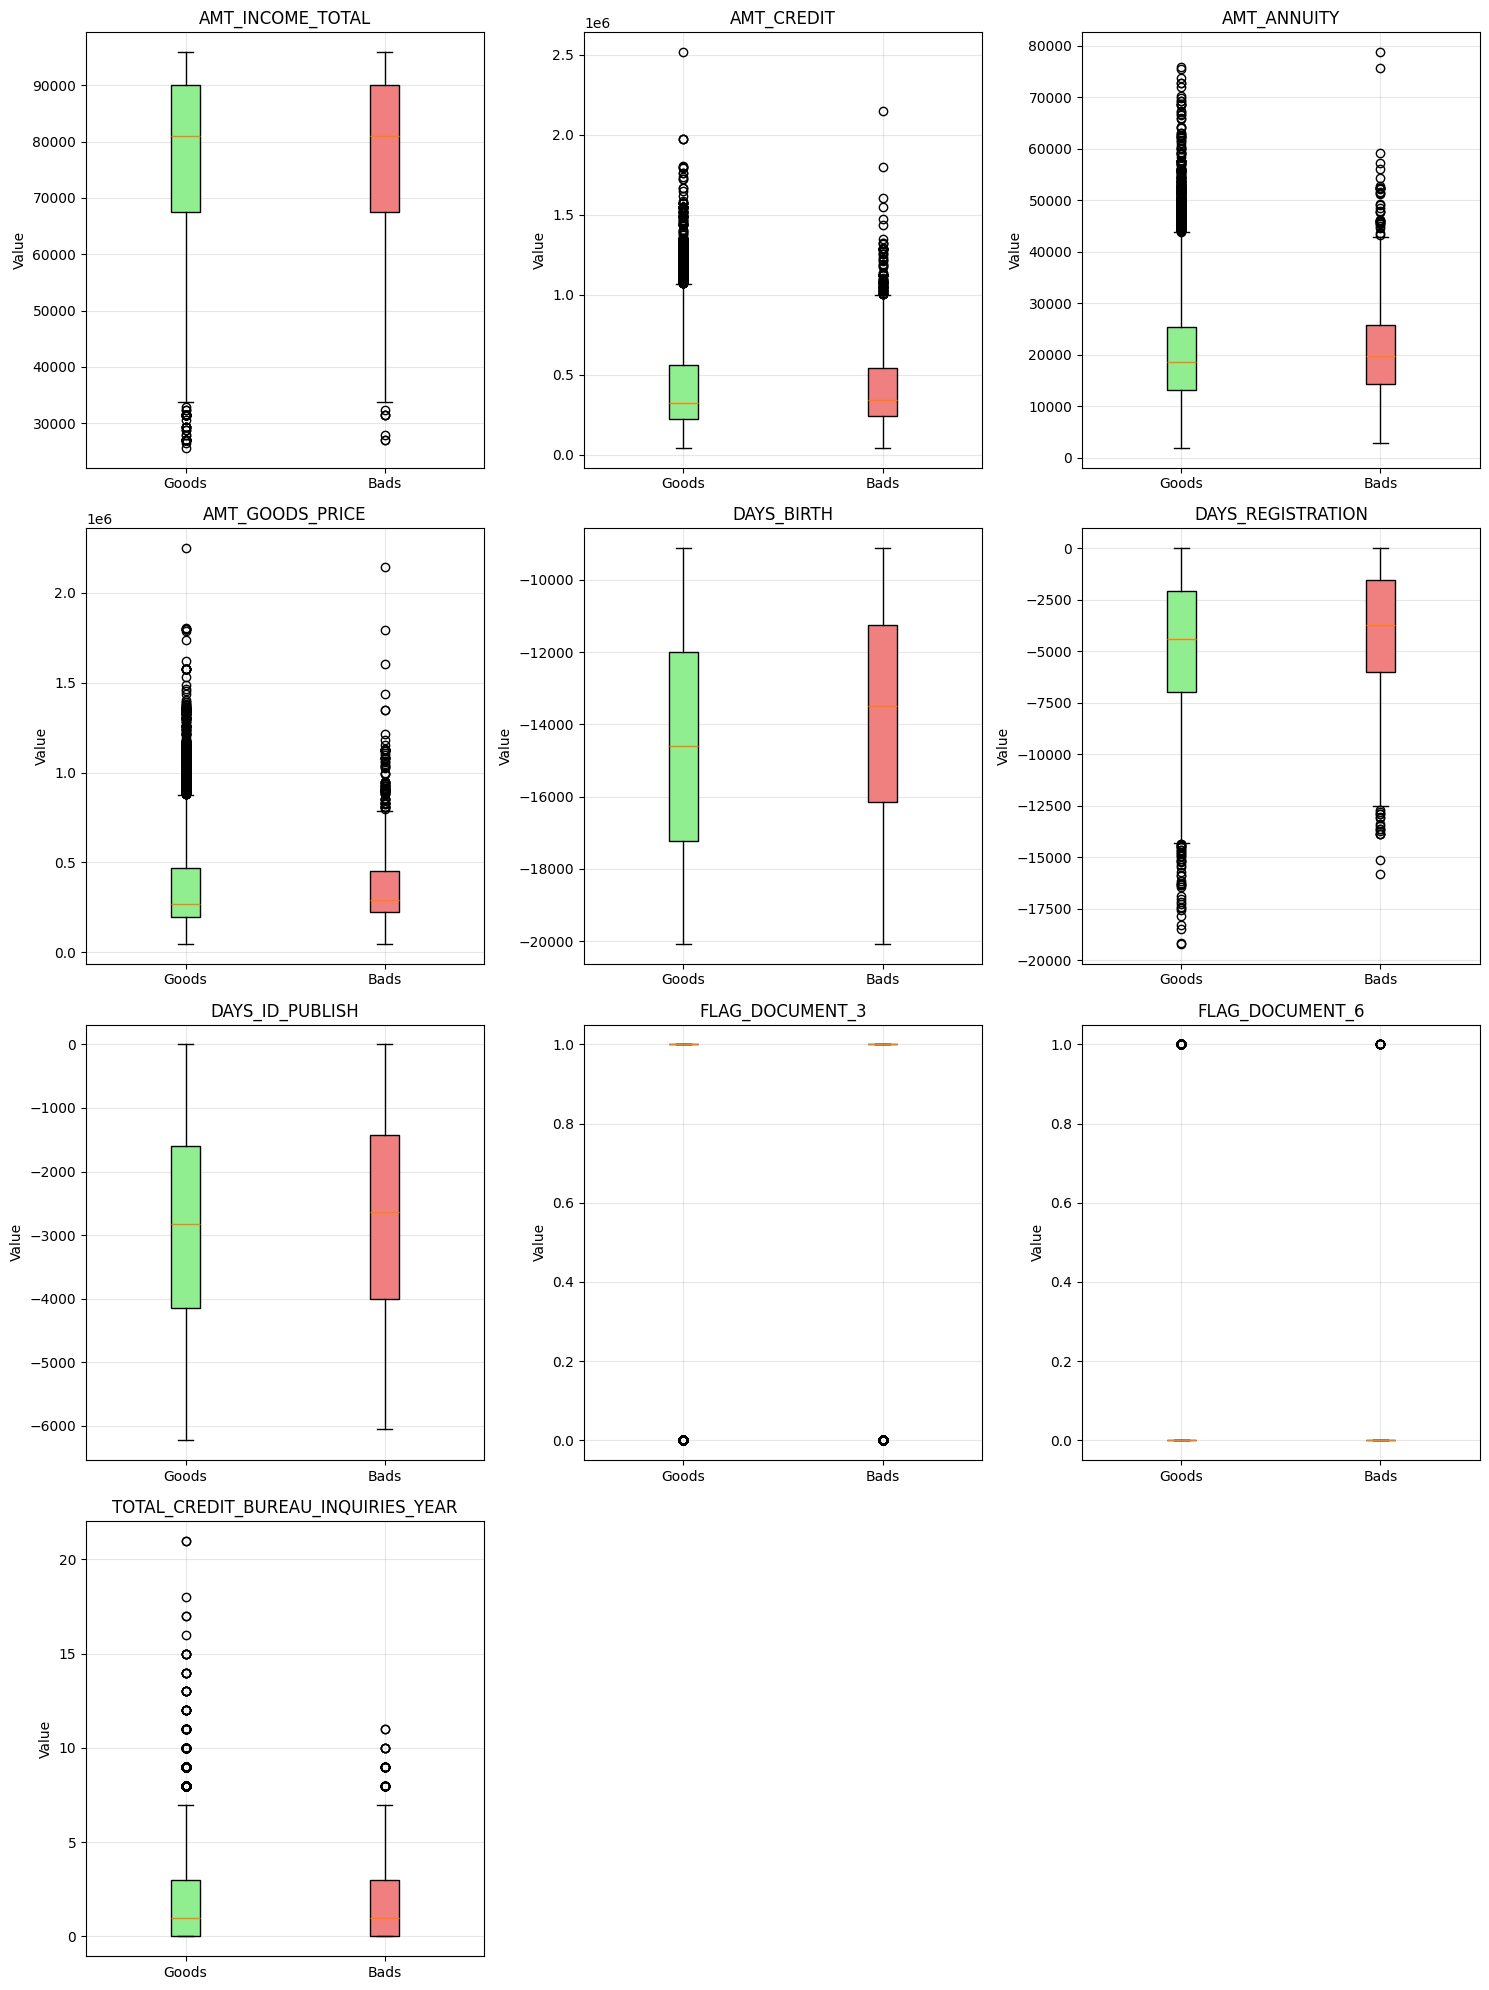


Plotted boxplots for 10 key features (showing goods vs bads)

SUMMARY
Total numeric features analyzed: 10
Features with outliers (|z| > 3): 8

Note: Outliers can be handled by capping/winsorizing before modeling


In [241]:
# Distribution Analysis and Outlier Detection for Application Data
print("="*80)
print("DISTRIBUTION ANALYSIS AND OUTLIER DETECTION - APPLICATION DATA")
print("="*80)

# Get numeric columns (excluding ID and target)
numeric_cols = [col for col in appData_filtered.select_dtypes(include=[np.number]).columns 
                if col not in ['SK_ID_CURR', 'TARGET']]

print(f"\nAnalyzing {len(numeric_cols)} numeric features...")

# Calculate z-scores for outlier detection
print("\n" + "-"*80)
print("OUTLIER DETECTION USING Z-SCORE (|z| > 3):")
print("-"*80)

outlier_summary = []
for col in numeric_cols:
    if appData_filtered[col].isnull().all():
        continue
    
    # Calculate z-scores (only for non-null values)
    values = appData_filtered[col].dropna()
    if len(values) == 0:
        continue
    
    mean = values.mean()
    std = values.std()
    
    if std == 0:  # Skip constant columns
        continue
    
    z_scores = np.abs((values - mean) / std)
    outliers = z_scores > 3
    outlier_count = outliers.sum()
    outlier_pct = (outlier_count / len(values)) * 100
    
    if outlier_count > 0:
        outlier_summary.append({
            'Column': col,
            'Outliers': outlier_count,
            'Percentage': outlier_pct,
            'Max Z-Score': z_scores.max(),
            'Min Value': values.min(),
            'Max Value': values.max(),
            'Mean': mean,
            'Std': std
        })

if outlier_summary:
    outlier_df = pd.DataFrame(outlier_summary)
    outlier_df = outlier_df.sort_values('Outliers', ascending=False)
    print(f"\nFound outliers in {len(outlier_df)} columns:")
    print(outlier_df.to_string(index=False))
else:
    print("No outliers found (|z| > 3) in numeric columns")

# Plot histograms for key numeric features
print("\n" + "-"*80)
print("HISTOGRAM PLOTS - KEY NUMERIC FEATURES:")
print("-"*80)

# Select all numeric features to plot
key_features = numeric_cols  # Plot all numeric features

if key_features:
    n_cols = 3
    n_rows = (len(key_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for idx, col in enumerate(key_features):
        ax = axes[idx]
        
        # Plot histogram for goods and bads separately
        goods = appData_filtered[appData_filtered['TARGET'] == 0][col].dropna()
        bads = appData_filtered[appData_filtered['TARGET'] == 1][col].dropna()
        
        if len(goods) > 0:
            ax.hist(goods, bins=50, alpha=0.5, label='Goods (TARGET=0)', color='green', density=True)
        if len(bads) > 0:
            ax.hist(bads, bins=50, alpha=0.5, label='Bads (TARGET=1)', color='red', density=True)
        
        ax.set_title(f'{col}\n(Goods: {len(goods):,}, Bads: {len(bads):,})')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(key_features), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"\nPlotted histograms for {len(key_features)} key features (showing goods vs bads)")

# Plot boxplots for key numeric features
print("\n" + "-"*80)
print("BOXPLOT PLOTS - KEY NUMERIC FEATURES:")
print("-"*80)

if key_features:
    n_cols = 3
    n_rows = (len(key_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for idx, col in enumerate(key_features):
        ax = axes[idx]
        
        # Prepare data for boxplot (goods and bads)
        data_to_plot = []
        labels = []
        
        goods = appData_filtered[appData_filtered['TARGET'] == 0][col].dropna()
        bads = appData_filtered[appData_filtered['TARGET'] == 1][col].dropna()
        
        if len(goods) > 0:
            data_to_plot.append(goods)
            labels.append('Goods')
        if len(bads) > 0:
            data_to_plot.append(bads)
            labels.append('Bads')
        
        if data_to_plot:
            bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
            bp['boxes'][0].set_facecolor('lightgreen')
            if len(bp['boxes']) > 1:
                bp['boxes'][1].set_facecolor('lightcoral')
            
            ax.set_title(f'{col}')
            ax.set_ylabel('Value')
            ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(key_features), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"\nPlotted boxplots for {len(key_features)} key features (showing goods vs bads)")

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"Total numeric features analyzed: {len(numeric_cols)}")
print(f"Features with outliers (|z| > 3): {len(outlier_summary)}")
print(f"\nNote: Outliers can be handled by capping/winsorizing before modeling")


In [242]:
# Bureau Data Filtering - Part 1: Filter raw bureau data (NO TARGET needed)
print("="*80)
print("VARIABLE SELECTION AND FILTERING FOR RAW BUREAU DATA (Before Aggregation)")
print("="*80)

bureauData_filtered = bureauData.copy()
cols_before = len([col for col in bureauData_filtered.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU']])

# Step 1: Remove logically impossible rows in bureau data
bad_mask = False

# 1) Negative debt or limit
for c in ['AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT']:
    if c in bureauData_filtered.columns:
        cond = bureauData_filtered[c] < 0
        dropped = cond.sum()
        if dropped > 0:
            print(f"  Dropping {dropped} rows where {c} is negative")
        bad_mask = cond if isinstance(bad_mask, bool) else (bad_mask | cond)

# 2) Debt greater than total sum
if {'AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM'}.issubset(bureauData_filtered.columns):
    cond = bureauData_filtered['AMT_CREDIT_SUM_DEBT'] > bureauData_filtered['AMT_CREDIT_SUM']
    dropped = cond.sum()
    if dropped > 0:
        print(f"  Dropping {dropped} rows where debt > total credit sum")
    bad_mask = cond if isinstance(bad_mask, bool) else (bad_mask | cond)

# 3) Overdue greater than debt
if {'AMT_CREDIT_SUM_OVERDUE','AMT_CREDIT_SUM_DEBT'}.issubset(bureauData_filtered.columns):
    cond = bureauData_filtered['AMT_CREDIT_SUM_OVERDUE'] > bureauData_filtered['AMT_CREDIT_SUM_DEBT']
    dropped = cond.sum()
    if dropped > 0:
        print(f"  Dropping {dropped} rows where overdue > debt")
    bad_mask = cond if isinstance(bad_mask, bool) else (bad_mask | cond)

# Drop the rows
if not isinstance(bad_mask, bool) and bad_mask.any():
    total_drop = bad_mask.sum()
    print(f"  Total rows dropped from all checks: {total_drop}")
    bureauData_filtered = bureauData_filtered.loc[~bad_mask]
else:
    print("  No debt/limit checks applied or no rows to drop (required columns missing)")


# Step 2: Remove variables with only 1 unique value (categorical AND numeric)
print("\n1. DROPPING VARIABLES WITH NO VARIATION (1 unique value):")
print("-" * 80)

# NOTE: Binary columns (2 unique values like 0/1, Y/N) are SAFE - they won't be dropped
# Only columns with exactly 1 unique value will be dropped
single_value_cols = []
for col in bureauData_filtered.columns:
    if col in ['SK_ID_CURR', 'SK_ID_BUREAU']:  # Skip ID columns
        continue
    
    # Only drop if column has exactly 1 unique value
    if bureauData_filtered[col].nunique(dropna=False) == 1:  # Check including NaN
        single_value_cols.append(col)
        unique_val = bureauData_filtered[col].dropna().unique()[0] if bureauData_filtered[col].dropna().nunique() > 0 else "all NaN"
        print(f"  Dropping: {col} (only 1 unique value: {unique_val})")

bureauData_filtered = bureauData_filtered.drop(columns=single_value_cols)
print(f"  Columns dropped: {len(single_value_cols)}")
remaining_cols = len([col for col in bureauData_filtered.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU']])
print(f"  Remaining columns: {remaining_cols}")


# Step 3: Drop variables with more than 55% missing data
print("\n2. DROPPING VARIABLES WITH >55% MISSING DATA:")
print("-" * 80)

total_rows = len(bureauData_filtered)
missing_threshold = 0.55

high_missing_cols = []
for col in bureauData_filtered.columns:
    if col in ['SK_ID_CURR', 'SK_ID_BUREAU']:
        continue
    
    missing_count = bureauData_filtered[col].isnull().sum()
    missing_pct = missing_count / total_rows
    
    if missing_pct > missing_threshold:
        high_missing_cols.append(col)
        print(f"  Dropping: {col} ({missing_pct*100:.2f}% missing - {missing_count:,} out of {total_rows:,})")

bureauData_filtered = bureauData_filtered.drop(columns=high_missing_cols)
print(f"  Columns dropped: {len(high_missing_cols)}")
remaining_cols = len([col for col in bureauData_filtered.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU']])
print(f"  Remaining columns: {remaining_cols}")

print("\n" + "="*80)
print("PART 1 SUMMARY - RAW BUREAU DATA FILTERING")
print("="*80)
print(f"Original feature columns: {cols_before}")
final_cols_part1 = len([col for col in bureauData_filtered.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU']])
print(f"Remaining feature columns: {final_cols_part1}")
print(f"Columns dropped: {cols_before - final_cols_part1}")
print(f"\nVariable name: bureauData_filtered")
print(f"Shape: {bureauData_filtered.shape}")
print("\n" + "="*80)


VARIABLE SELECTION AND FILTERING FOR RAW BUREAU DATA (Before Aggregation)
  Dropping 8418 rows where AMT_CREDIT_SUM_DEBT is negative
  Dropping 351 rows where AMT_CREDIT_SUM_LIMIT is negative
  Dropping 29642 rows where debt > total credit sum
  Dropping 9198 rows where overdue > debt
  Total rows dropped from all checks: 38866

1. DROPPING VARIABLES WITH NO VARIATION (1 unique value):
--------------------------------------------------------------------------------
  Columns dropped: 0
  Remaining columns: 15

2. DROPPING VARIABLES WITH >55% MISSING DATA:
--------------------------------------------------------------------------------
  Dropping: AMT_CREDIT_MAX_OVERDUE (65.43% missing - 1,097,665 out of 1,677,562)
  Dropping: AMT_ANNUITY (71.45% missing - 1,198,557 out of 1,677,562)
  Columns dropped: 2
  Remaining columns: 13

PART 1 SUMMARY - RAW BUREAU DATA FILTERING
Original feature columns: 15
Remaining feature columns: 13
Columns dropped: 2

Variable name: bureauData_filtered
Sha

In [243]:
# Keep only rows with the most common CREDIT_CURRENCY value
print("\n" + "="*80)
print("FILTERING CREDIT_CURRENCY - KEEPING MOST COMMON VALUE")
print("="*80)

col = 'CREDIT_CURRENCY'
rows_before = len(bureauData_filtered)

if col in bureauData_filtered.columns:
    # Get value counts
    value_counts = bureauData_filtered[col].value_counts()
    
    if len(value_counts) > 0:
        # Get the most common value (highest count)
        most_common_value = value_counts.index[0]
        most_common_count = value_counts.iloc[0]
        total_count = value_counts.sum()
        
        print(f"  CREDIT_CURRENCY value counts:")
        for val, count in value_counts.items():
            pct = (count / total_count) * 100
            marker = " ← KEEPING" if val == most_common_value else ""
            print(f"    {val}: {count:,} ({pct:.2f}%){marker}")
        
        print(f"\n  Keeping only: '{most_common_value}' ({most_common_count:,} rows, {most_common_count/total_count*100:.2f}%)")
        
        # Filter to keep only the most common value
        bureauData_filtered = bureauData_filtered[bureauData_filtered[col] == most_common_value]
        
        rows_after = len(bureauData_filtered)
        rows_dropped = rows_before - rows_after
        
        print(f"\n  Rows before: {rows_before:,}")
        print(f"  Rows after: {rows_after:,}")
        print(f"  Rows dropped: {rows_dropped:,} ({rows_dropped/rows_before*100:.2f}%)")
        
        # Drop CREDIT_CURRENCY column since it now has only one unique value (no variation)
        print(f"\n  Dropping '{col}' column (all remaining rows have the same value: '{most_common_value}')")
        bureauData_filtered = bureauData_filtered.drop(columns=[col])
        print(f"  ✓ Column '{col}' dropped successfully")
    else:
        print(f"  ⚠ {col} has no values")
else:
    print(f"  ⚠ Column {col} not found in bureauData_filtered")

print("\n" + "="*80)


FILTERING CREDIT_CURRENCY - KEEPING MOST COMMON VALUE
  CREDIT_CURRENCY value counts:
    currency 1: 1,676,162 (99.92%) ← KEEPING
    currency 2: 1,216 (0.07%)
    currency 3: 174 (0.01%)
    currency 4: 10 (0.00%)

  Keeping only: 'currency 1' (1,676,162 rows, 99.92%)

  Rows before: 1,677,562
  Rows after: 1,676,162
  Rows dropped: 1,400 (0.08%)

  Dropping 'CREDIT_CURRENCY' column (all remaining rows have the same value: 'currency 1')
  ✓ Column 'CREDIT_CURRENCY' dropped successfully




DISTRIBUTION ANALYSIS AND OUTLIER DETECTION - BUREAU DATA (RAW)
Note: Bureau data is not aggregated yet, so no goods vs bads comparison

Analyzing 10 numeric features...

--------------------------------------------------------------------------------
OUTLIER DETECTION USING Z-SCORE (|z| > 3):
--------------------------------------------------------------------------------

Found outliers in 9 columns:
                Column  Outliers  Percentage  Max Z-Score  Min Value   Max Value          Mean          Std
   DAYS_CREDIT_ENDDATE     36719    2.332147     8.610976   -42060.0     31199.0    474.625415 4.939582e+03
        AMT_CREDIT_SUM     16524    0.985831   528.684847        0.0 585000000.0 352733.683436 1.105852e+06
  AMT_CREDIT_SUM_LIMIT     16085    1.468806   107.645827        0.0   4500000.0   5489.612146 4.175276e+04
   AMT_CREDIT_SUM_DEBT     15963    1.125117   266.393335        0.0 170100000.0 131425.281885 6.380361e+05
    CNT_CREDIT_PROLONG      9037    0.539148    92.63

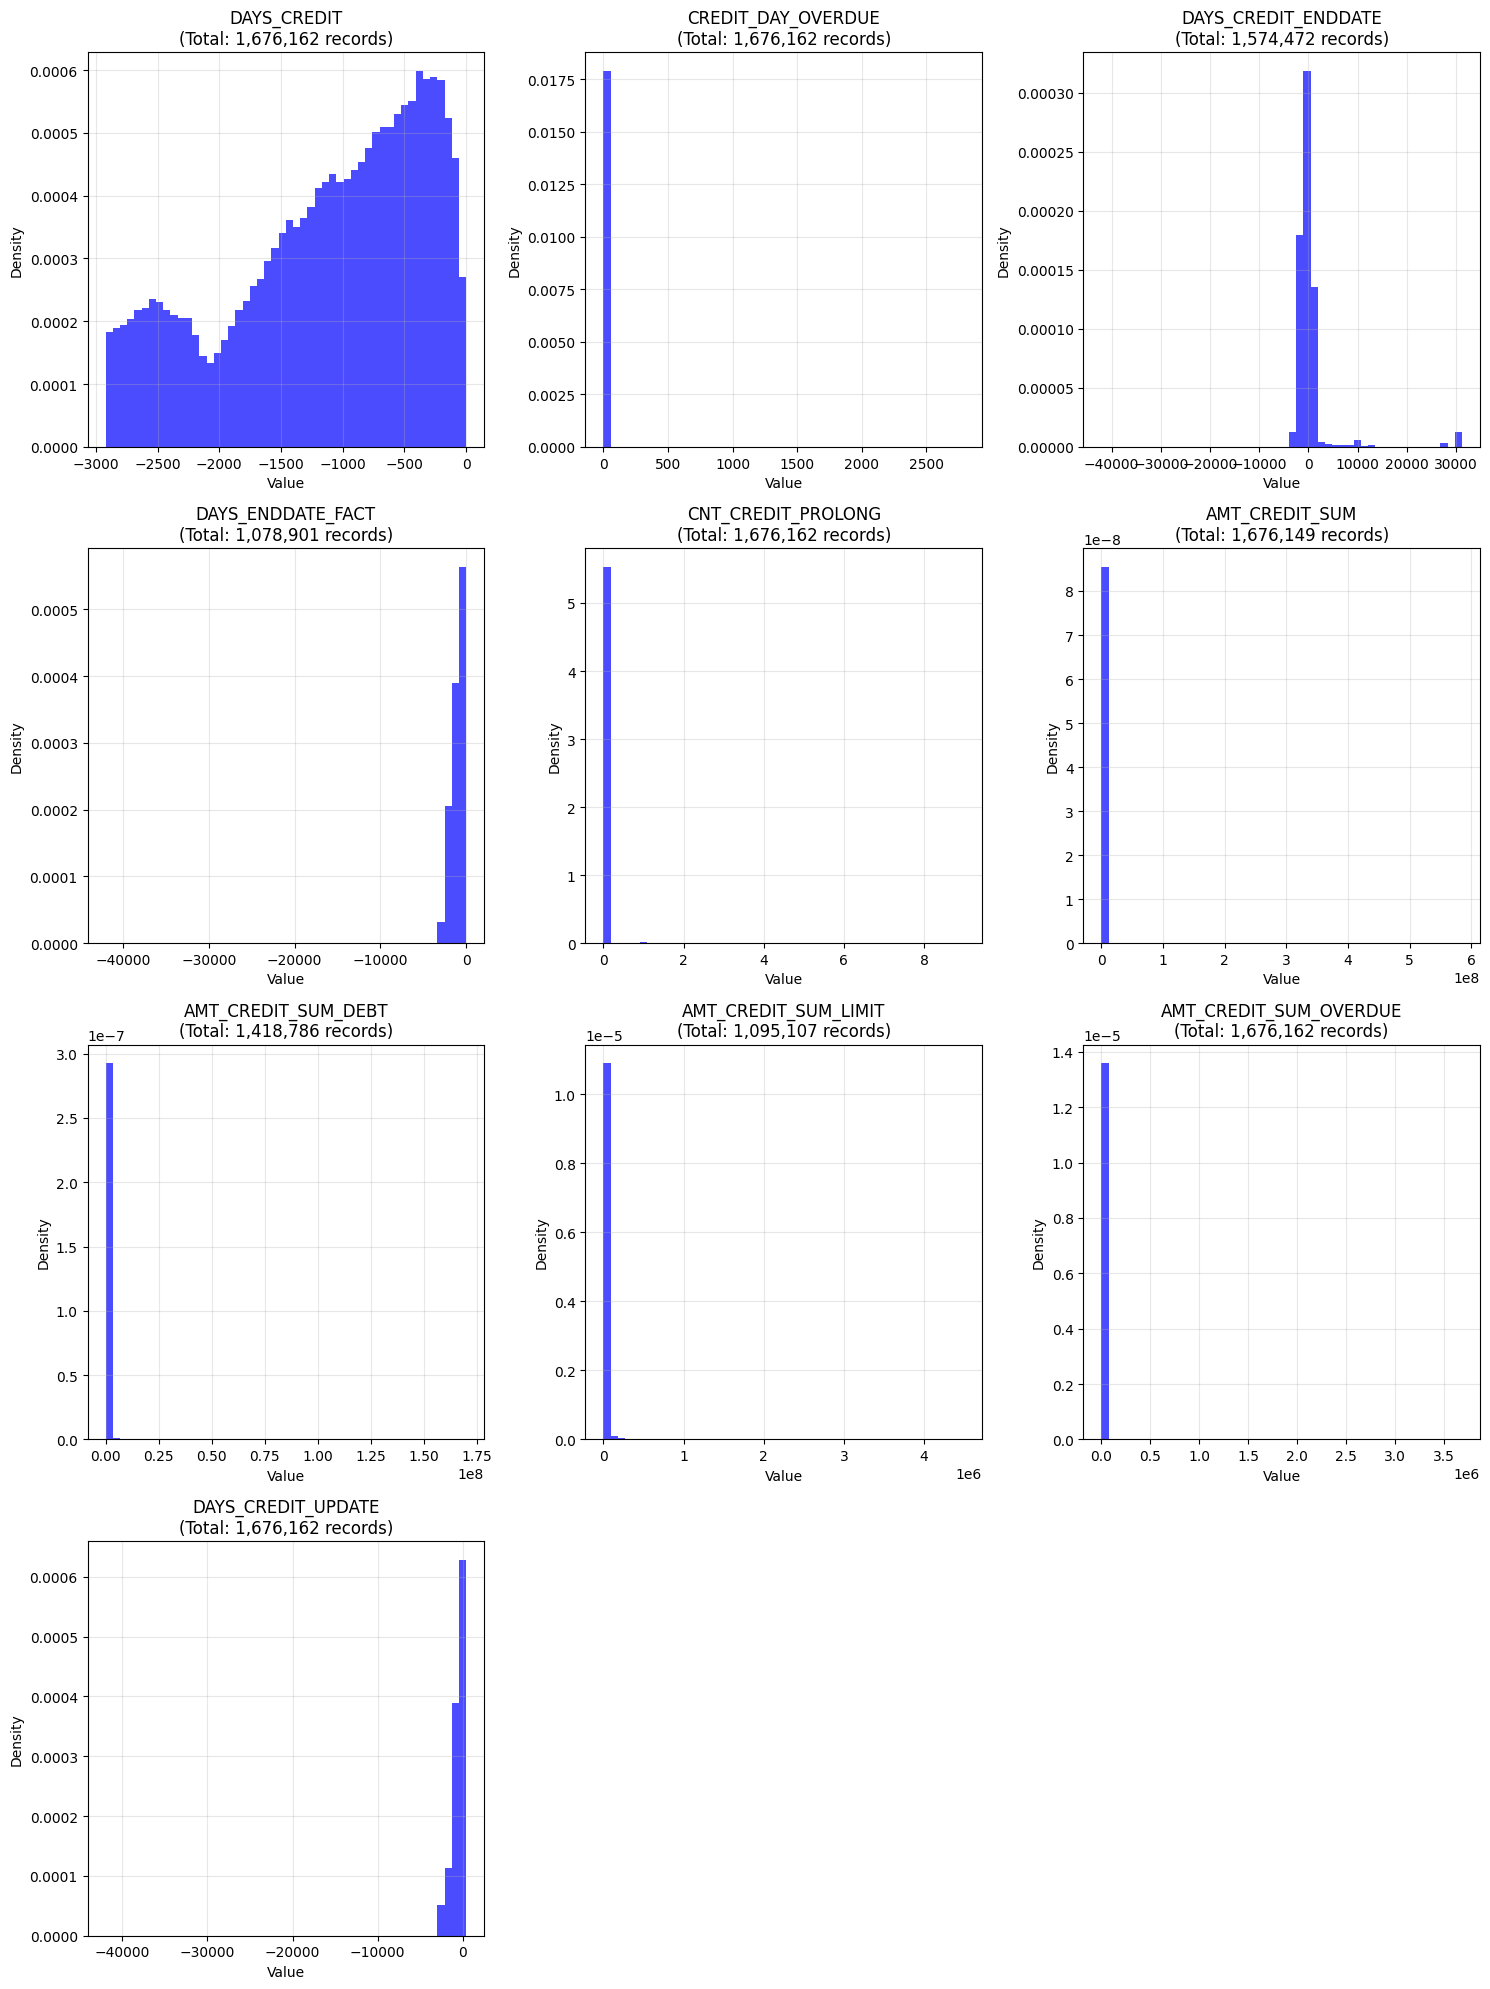


Plotted histograms for 10 features

--------------------------------------------------------------------------------
BOXPLOT PLOTS - ALL NUMERIC FEATURES:
--------------------------------------------------------------------------------


/var/folders/wr/yrbny12n0vxf_hr5g_xl8tl00000gn/T/ipykernel_38487/3973846775.py:114: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([values], labels=[col], patch_artist=True)
/var/folders/wr/yrbny12n0vxf_hr5g_xl8tl00000gn/T/ipykernel_38487/3973846775.py:114: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([values], labels=[col], patch_artist=True)
/var/folders/wr/yrbny12n0vxf_hr5g_xl8tl00000gn/T/ipykernel_38487/3973846775.py:114: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([values], labels=[col], patch_artist=True)
/var/folders/wr/yrbny12n0vxf_hr5g_xl8tl00000gn/T/ipykernel

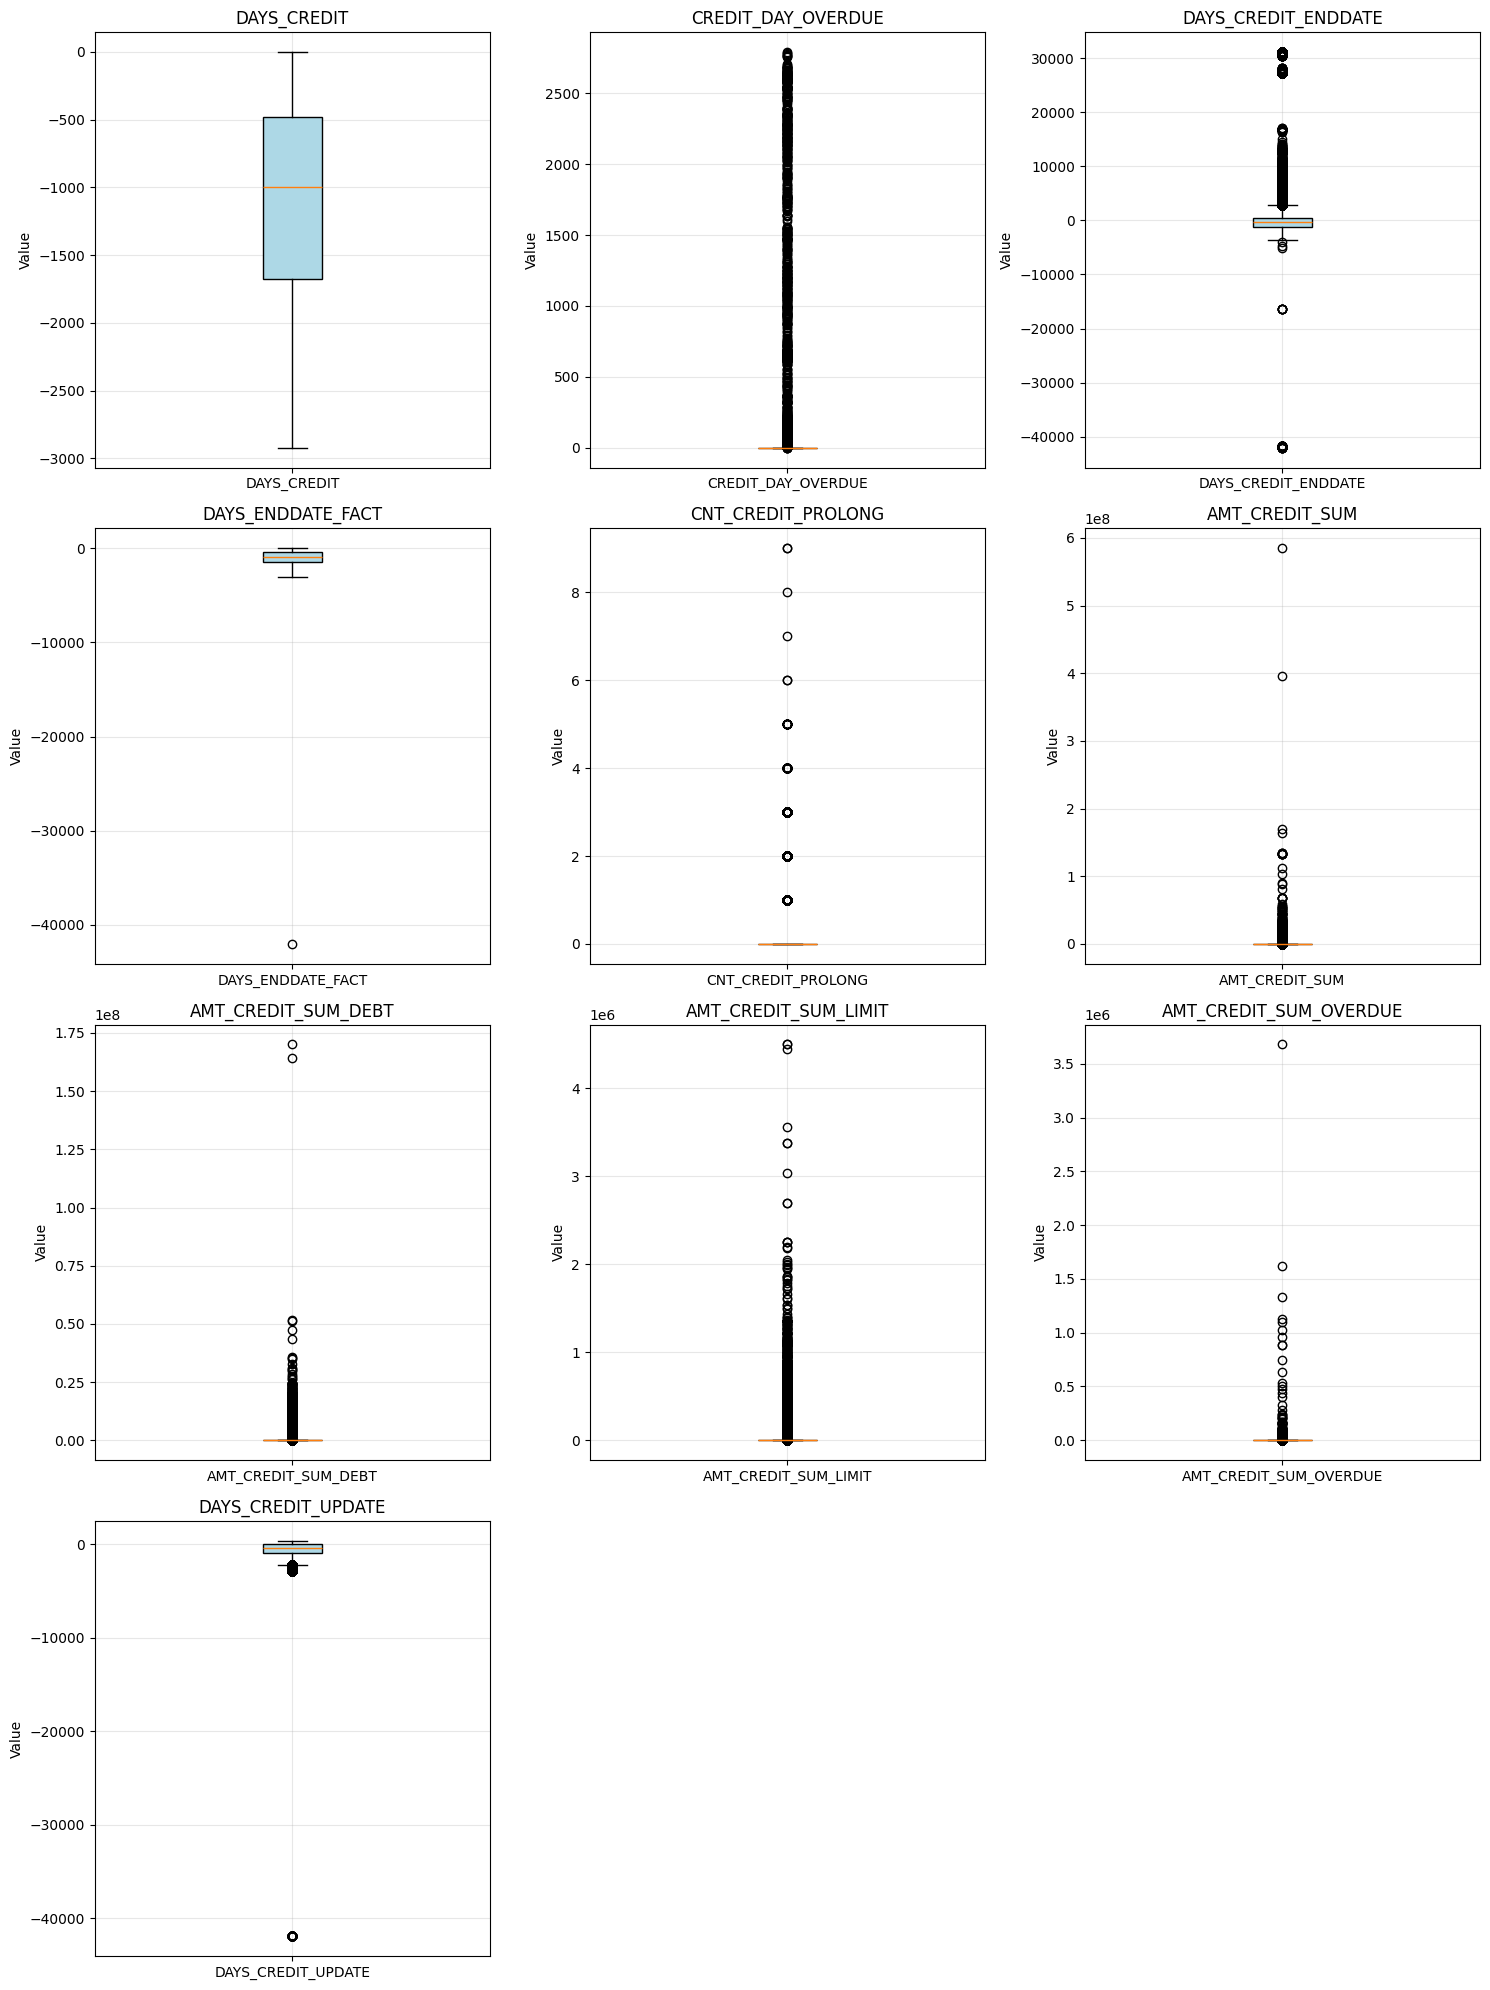


Plotted boxplots for 10 features

SUMMARY
Total numeric features analyzed: 10
Features with outliers (|z| > 3): 9

Note: Outliers can be handled by capping/winsorizing before aggregation
      This will prevent outliers from skewing aggregated features (sum/mean)


In [244]:

# Distribution Analysis and Outlier Detection for Bureau Data (Raw, Before Aggregation)
print("\n" + "="*80)
print("DISTRIBUTION ANALYSIS AND OUTLIER DETECTION - BUREAU DATA (RAW)")
print("="*80)
print("Note: Bureau data is not aggregated yet, so no goods vs bads comparison")

# Get numeric columns (excluding ID columns)
numeric_cols = [col for col in bureauData_filtered.select_dtypes(include=[np.number]).columns 
                if col not in ['SK_ID_CURR', 'SK_ID_BUREAU']]

print(f"\nAnalyzing {len(numeric_cols)} numeric features...")

# Calculate z-scores for outlier detection
print("\n" + "-"*80)
print("OUTLIER DETECTION USING Z-SCORE (|z| > 3):")
print("-"*80)

outlier_summary = []
for col in numeric_cols:
    if bureauData_filtered[col].isnull().all():
        continue
    
    # Calculate z-scores (only for non-null values)
    values = bureauData_filtered[col].dropna()
    if len(values) == 0:
        continue
    
    mean = values.mean()
    std = values.std()
    
    if std == 0:  # Skip constant columns
        continue
    
    z_scores = np.abs((values - mean) / std)
    outliers = z_scores > 3
    outlier_count = outliers.sum()
    outlier_pct = (outlier_count / len(values)) * 100
    
    if outlier_count > 0:
        outlier_summary.append({
            'Column': col,
            'Outliers': outlier_count,
            'Percentage': outlier_pct,
            'Max Z-Score': z_scores.max(),
            'Min Value': values.min(),
            'Max Value': values.max(),
            'Mean': mean,
            'Std': std
        })

if outlier_summary:
    outlier_df = pd.DataFrame(outlier_summary)
    outlier_df = outlier_df.sort_values('Outliers', ascending=False)
    print(f"\nFound outliers in {len(outlier_df)} columns:")
    print(outlier_df.to_string(index=False))
else:
    print("No outliers found (|z| > 3) in numeric columns")

# Plot histograms for all numeric features
print("\n" + "-"*80)
print("HISTOGRAM PLOTS - ALL NUMERIC FEATURES:")
print("-"*80)

# Select all numeric features to plot
key_features = numeric_cols  # Plot all numeric features

if key_features:
    n_cols = 3
    n_rows = (len(key_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for idx, col in enumerate(key_features):
        ax = axes[idx]
        
        # Plot histogram (no goods vs bads since not aggregated yet)
        values = bureauData_filtered[col].dropna()
        
        if len(values) > 0:
            ax.hist(values, bins=50, alpha=0.7, color='blue', density=True)
            ax.set_title(f'{col}\n(Total: {len(values):,} records)')
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
            ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(key_features), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"\nPlotted histograms for {len(key_features)} features")

# Plot boxplots for all numeric features
print("\n" + "-"*80)
print("BOXPLOT PLOTS - ALL NUMERIC FEATURES:")
print("-"*80)

if key_features:
    n_cols = 3
    n_rows = (len(key_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for idx, col in enumerate(key_features):
        ax = axes[idx]
        
        # Plot boxplot (no goods vs bads since not aggregated yet)
        values = bureauData_filtered[col].dropna()
        
        if len(values) > 0:
            bp = ax.boxplot([values], labels=[col], patch_artist=True)
            bp['boxes'][0].set_facecolor('lightblue')
            ax.set_title(f'{col}')
            ax.set_ylabel('Value')
            ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(key_features), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"\nPlotted boxplots for {len(key_features)} features")

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"Total numeric features analyzed: {len(numeric_cols)}")
print(f"Features with outliers (|z| > 3): {len(outlier_summary)}")
print(f"\nNote: Outliers can be handled by capping/winsorizing before aggregation")
print(f"      This will prevent outliers from skewing aggregated features (sum/mean)")


In [245]:
# Drop rows where DAYS_CREDIT_ENDDATE is a POSITIVE outlier (|z| > 3 and value > 0)
# Note: Negative outliers are kept as they represent past loans (days in the past)
print("\n" + "="*80)
print("REMOVING POSITIVE OUTLIERS FOR DAYS_CREDIT_ENDDATE")
print("="*80)

col = 'DAYS_CREDIT_ENDDATE'
rows_before = len(bureauData_filtered)

if col in bureauData_filtered.columns:
    vals = bureauData_filtered[col]
    non_null = vals.dropna()
    
    if len(non_null) > 0:
        mu = non_null.mean()
        sigma = non_null.std()
        
        if sigma and sigma != 0:
            # Calculate z-scores for all values (including NaN)
            z_scores = (vals - mu) / sigma
            
            # Identify positive outliers: value > 0 AND |z| > 3
            pos_outlier_mask = (vals > 0) & (z_scores.abs() > 3)
            n_pos_outliers = int(pos_outlier_mask.sum())
            
            if n_pos_outliers > 0:
                print(f"  Found {n_pos_outliers} positive outliers in {col} (|z| > 3 and value > 0)")
                print(f"  Dropping these rows...")
                
                # Show some stats about what we're dropping
                outlier_vals = vals[pos_outlier_mask]
                print(f"    Min positive outlier value: {outlier_vals.min()}")
                print(f"    Max positive outlier value: {outlier_vals.max()}")
                
                # Drop the rows
                bureauData_filtered = bureauData_filtered.loc[~pos_outlier_mask]
                
                rows_after = len(bureauData_filtered)
                rows_dropped = rows_before - rows_after
                
                print(f"\n  Rows before: {rows_before:,}")
                print(f"  Rows after: {rows_after:,}")
                print(f"  Rows dropped: {rows_dropped:,} ({rows_dropped/rows_before*100:.2f}%)")
            else:
                print(f"  No positive outliers found in {col} (|z| > 3 and value > 0)")
                print(f"  All outliers are negative (past loans) - keeping them")
        else:
            print(f"  ⚠ Cannot compute z-scores: std is zero for {col}")
    else:
        print(f"  ⚠ {col} has no non-null values")
else:
    print(f"  ⚠ Column {col} not found in bureauData_filtered")

print("\n" + "="*80)




REMOVING POSITIVE OUTLIERS FOR DAYS_CREDIT_ENDDATE
  Found 36579 positive outliers in DAYS_CREDIT_ENDDATE (|z| > 3 and value > 0)
  Dropping these rows...
    Min positive outlier value: 16376.0
    Max positive outlier value: 31199.0

  Rows before: 1,676,162
  Rows after: 1,639,583
  Rows dropped: 36,579 (2.18%)



In [246]:
bureauData_filtered.isnull().sum()

SK_ID_CURR                     0
SK_ID_BUREAU                   0
CREDIT_ACTIVE                  0
DAYS_CREDIT                    0
CREDIT_DAY_OVERDUE             0
DAYS_CREDIT_ENDDATE       101690
DAYS_ENDDATE_FACT         567556
CNT_CREDIT_PROLONG             0
AMT_CREDIT_SUM                13
AMT_CREDIT_SUM_DEBT       257118
AMT_CREDIT_SUM_LIMIT      566974
AMT_CREDIT_SUM_OVERDUE         0
CREDIT_TYPE                    0
DAYS_CREDIT_UPDATE             0
dtype: int64

In [247]:
appData_filtered.isnull().sum()

SK_ID_CURR                               0
TARGET                                   0
NAME_CONTRACT_TYPE                       0
AMT_INCOME_TOTAL                         0
AMT_CREDIT                               0
AMT_ANNUITY                              1
AMT_GOODS_PRICE                          0
NAME_INCOME_TYPE                         0
NAME_EDUCATION_TYPE                      0
DAYS_BIRTH                               0
DAYS_REGISTRATION                        0
DAYS_ID_PUBLISH                          0
OCCUPATION_TYPE                       5113
ORGANIZATION_TYPE                        0
FLAG_DOCUMENT_3                          0
FLAG_DOCUMENT_6                          0
TOTAL_CREDIT_BUREAU_INQUIRIES_YEAR       0
dtype: int64

In [248]:
# Aggregation of filtered bureau data on SK_ID_CURR
print("="*80)
print("AGGREGATING BUREAU DATA ON SK_ID_CURR")
print("="*80)

# Check current shape
print(f"\nInput data shape: {bureauData_filtered.shape}")
print(f"Unique SK_ID_CURR: {bureauData_filtered['SK_ID_CURR'].nunique():,}")

# Get list of columns to aggregate (exclude ID columns)
id_cols = ['SK_ID_CURR', 'SK_ID_BUREAU']
agg_cols = [col for col in bureauData_filtered.columns if col not in id_cols]

print(f"\nColumns to aggregate: {len(agg_cols)}")
print(f"Columns: {', '.join(agg_cols)}")

# Perform aggregation using groupby
print("\nPerforming aggregation...")

# Start with count of bureau records
bureauData_agg = bureauData_filtered.groupby('SK_ID_CURR').agg({
    'SK_ID_BUREAU': 'count',
})

# Rename the count column
bureauData_agg = bureauData_agg.rename(columns={'SK_ID_BUREAU': 'NUM_BUREAU_RECORDS'})

# Get categorical and numeric columns
categorical_cols = bureauData_filtered[agg_cols].select_dtypes(include=['object']).columns.tolist()
numeric_cols = bureauData_filtered[agg_cols].select_dtypes(include=[np.number]).columns.tolist()

# Add categorical mode aggregations
for col in categorical_cols:
    if col in agg_cols:
        def safe_mode(x):
            """Safely get mode, handling None/NaN values"""
            try:
                # Drop NaN values before calculating mode
                x_clean = x.dropna()
                if len(x_clean) == 0:
                    return np.nan
                mode_result = x_clean.mode()
                if not mode_result.empty and len(mode_result) > 0:
                    return mode_result.iloc[0]
                else:
                    return np.nan
            except (IndexError, AttributeError, TypeError):
                return np.nan
        
        mode_series = bureauData_filtered.groupby('SK_ID_CURR')[col].apply(safe_mode)
        bureauData_agg[f'{col}_MODE'] = mode_series

# Add numeric aggregations
for col in numeric_cols:
    if col in agg_cols:
        # For amount, count, overdue, and prolong columns: sum, mean, median, max, min
        if 'AMT' in col or 'CNT' in col or 'OVERDUE' in col or 'PROLONG' in col:
            bureauData_agg[f'{col}_SUM'] = bureauData_filtered.groupby('SK_ID_CURR')[col].sum()
            bureauData_agg[f'{col}_MEAN'] = bureauData_filtered.groupby('SK_ID_CURR')[col].mean()
            bureauData_agg[f'{col}_MEDIAN'] = bureauData_filtered.groupby('SK_ID_CURR')[col].median()
            bureauData_agg[f'{col}_MAX'] = bureauData_filtered.groupby('SK_ID_CURR')[col].max()
            bureauData_agg[f'{col}_MIN'] = bureauData_filtered.groupby('SK_ID_CURR')[col].min()
        # For DAYS columns: min, max, mean, median (time-based features)
        elif 'DAYS' in col:
            bureauData_agg[f'{col}_MIN'] = bureauData_filtered.groupby('SK_ID_CURR')[col].min()
            bureauData_agg[f'{col}_MAX'] = bureauData_filtered.groupby('SK_ID_CURR')[col].max()
            bureauData_agg[f'{col}_MEAN'] = bureauData_filtered.groupby('SK_ID_CURR')[col].mean()
            bureauData_agg[f'{col}_MEDIAN'] = bureauData_filtered.groupby('SK_ID_CURR')[col].median()
        # For other numeric columns: sum, mean, median, max, min
        else:
            bureauData_agg[f'{col}_SUM'] = bureauData_filtered.groupby('SK_ID_CURR')[col].sum()
            bureauData_agg[f'{col}_MEAN'] = bureauData_filtered.groupby('SK_ID_CURR')[col].mean()
            bureauData_agg[f'{col}_MEDIAN'] = bureauData_filtered.groupby('SK_ID_CURR')[col].median()
            bureauData_agg[f'{col}_MAX'] = bureauData_filtered.groupby('SK_ID_CURR')[col].max()
            bureauData_agg[f'{col}_MIN'] = bureauData_filtered.groupby('SK_ID_CURR')[col].min()

# Reset index to make SK_ID_CURR a column
bureauData_agg = bureauData_agg.reset_index()

# Clean up the DataFrame: ensure proper dtypes and handle None/NaN values
print("\nCleaning up aggregated data...")
for col in bureauData_agg.columns:
    if col != 'SK_ID_CURR':
        # Replace None with NaN for all columns
        if bureauData_agg[col].dtype == 'object':
            # For object columns (like mode), replace None with NaN, then try to convert to numeric if possible
            bureauData_agg[col] = bureauData_agg[col].replace([None], np.nan)
            # Try to convert to numeric if all values are numeric
            try:
                bureauData_agg[col] = pd.to_numeric(bureauData_agg[col], errors='coerce')
            except:
                pass
        else:
            # For numeric columns, replace None with NaN
            bureauData_agg[col] = bureauData_agg[col].replace([None], np.nan)
            # Ensure it's float64 to handle NaN properly
            if bureauData_agg[col].dtype in ['int64', 'int32']:
                # Convert int to float if there are any NaN values
                if bureauData_agg[col].isna().any():
                    bureauData_agg[col] = bureauData_agg[col].astype('float64')

print(f"\nOutput data shape: {bureauData_agg.shape}")
print(f"Unique SK_ID_CURR in aggregated data: {bureauData_agg['SK_ID_CURR'].nunique():,}")

# Show summary statistics
print("\n" + "-"*80)
print("AGGREGATION SUMMARY")
print("-"*80)
print(f"Rows before aggregation: {len(bureauData_filtered):,}")
print(f"Rows after aggregation: {len(bureauData_agg):,}")
print(f"Reduction: {len(bureauData_filtered) - len(bureauData_agg):,} rows ({((len(bureauData_filtered) - len(bureauData_agg)) / len(bureauData_filtered) * 100):.2f}%)")
print(f"\nFeatures created: {len(bureauData_agg.columns) - 1}")  # -1 for SK_ID_CURR

# Display first few rows
print("\n" + "-"*80)
print("SAMPLE OF AGGREGATED DATA (first 5 rows):")
print("-"*80)
print(bureauData_agg.head())

# Display column names
print("\n" + "-"*80)
print("AGGREGATED FEATURE NAMES:")
print("-"*80)
for i, col in enumerate(bureauData_agg.columns, 1):
    if col != 'SK_ID_CURR':
        print(f"{i}. {col}")

# Display data types and missing values
print("\n" + "-"*80)
print("DATA TYPES AND MISSING VALUES:")
print("-"*80)
try:
    bureauData_agg.info()
except TypeError as e:
    # Fallback if .info() fails - display manually
    print(f"Shape: {bureauData_agg.shape}")
    print(f"\nColumn dtypes:")
    for col in bureauData_agg.columns:
        print(f"  {col}: {bureauData_agg[col].dtype}")
    print(f"\nMissing values:")
    missing = bureauData_agg.isnull().sum()
    for col in bureauData_agg.columns:
        if missing[col] > 0:
            print(f"  {col}: {missing[col]} ({missing[col]/len(bureauData_agg)*100:.2f}%)")

print("\n" + "="*80)
print("AGGREGATION COMPLETE")
print("="*80)
print(f"\nVariable name: bureauData_agg")
print(f"Shape: {bureauData_agg.shape}")

AGGREGATING BUREAU DATA ON SK_ID_CURR

Input data shape: (1639583, 14)
Unique SK_ID_CURR: 303,408

Columns to aggregate: 12
Columns: CREDIT_ACTIVE, DAYS_CREDIT, CREDIT_DAY_OVERDUE, DAYS_CREDIT_ENDDATE, DAYS_ENDDATE_FACT, CNT_CREDIT_PROLONG, AMT_CREDIT_SUM, AMT_CREDIT_SUM_DEBT, AMT_CREDIT_SUM_LIMIT, AMT_CREDIT_SUM_OVERDUE, CREDIT_TYPE, DAYS_CREDIT_UPDATE

Performing aggregation...

Cleaning up aggregated data...

Output data shape: (303408, 50)
Unique SK_ID_CURR in aggregated data: 303,408

--------------------------------------------------------------------------------
AGGREGATION SUMMARY
--------------------------------------------------------------------------------
Rows before aggregation: 1,639,583
Rows after aggregation: 303,408
Reduction: 1,336,175 rows (81.49%)

Features created: 49

--------------------------------------------------------------------------------
SAMPLE OF AGGREGATED DATA (first 5 rows):
---------------------------------------------------------------------------

In [249]:
# Merging application data with bureau data
print("\n" + "="*80)
print("MERGING APPLICATION DATA WITH BUREAU DATA")
print("="*80)

# Check data shapes before merge
print(f"\nBefore merge:")
print(f"  Application data (appData_filtered): {appData_filtered.shape}")
print(f"  Bureau data (bureauData_agg): {bureauData_agg.shape}")

# Perform LEFT JOIN: Application data on LEFT, Bureau data on RIGHT
# This keeps ALL application records and adds bureau data where available
print("\nPerforming LEFT JOIN (application data on left)...")
print("  - Keeps ALL rows from application data")
print("  - Adds matching bureau data where available")
print("  - Fills with NaN for customers without bureau history")

merged_data = appData_filtered.merge(bureauData_agg, on='SK_ID_CURR', how='left')

print(f"\nAfter merge:")
print(f"  Merged data: {merged_data.shape}")
print(f"  Columns added: {len(merged_data.columns) - len(appData_filtered.columns)}")

# Check merge results
print("\n" + "-"*80)
print("MERGE RESULT ANALYSIS")
print("-"*80)

# Count customers with and without bureau history
customers_with_bureau = merged_data['NUM_BUREAU_RECORDS'].notna().sum()
customers_without_bureau = merged_data['NUM_BUREAU_RECORDS'].isna().sum()

print(f"\nCustomers with bureau history: {customers_with_bureau:,} ({customers_with_bureau/len(merged_data)*100:.2f}%)")
print(f"Customers without bureau history: {customers_without_bureau:,} ({customers_without_bureau/len(merged_data)*100:.2f}%)")

# Get all bureau columns (all columns except application data columns)
bureau_cols = [col for col in merged_data.columns if col not in appData_filtered.columns]

print("\n" + "-"*80)
print("FILLING MISSING VALUES (SCORECARD-SAFE)")
print("-"*80)

# --- CATEGORICAL COLUMNS ---
categorical_cols = ['OCCUPATION_TYPE'] + [col for col in bureau_cols if col != 'SK_ID_CURR']

for col in categorical_cols:
    if col in merged_data.columns:
        missing_before = merged_data[col].isna().sum()
        if missing_before > 0:
            merged_data[col] = merged_data[col].fillna("Missing")
            print(f"  {col}: {missing_before:,} missing values filled with 'Missing'")
    else:
        print(f"  ⚠ {col}: Column not found in merged data")

# --- NUMERIC COLUMNS ---
numeric_cols = ['AMT_ANNUITY'] + [col for col in bureau_cols if col not in categorical_cols and col != 'SK_ID_CURR']

for col in numeric_cols:
    if col in merged_data.columns:
        missing_before = merged_data[col].isna().sum()
        if missing_before > 0:
            # Create missing flag
            merged_data[col + '_MISSING'] = merged_data[col].isna().astype(int)
            # Fill with median (or leave as NaN if your WOE binning supports it)
            median_value = merged_data[col].median()
            merged_data[col] = merged_data[col].fillna(median_value)
            print(f"  {col}: {missing_before:,} missing values handled (filled with median {median_value} and missing flag created)")
    else:
        print(f"  ⚠ {col}: Column not found in merged data")


# Display summary
print("\n" + "="*80)
print("MERGE COMPLETE")
print("="*80)
print(f"\nFinal merged dataset:")
print(f"  Shape: {merged_data.shape}")
print(f"  Rows: {len(merged_data):,}")
print(f"  Columns: {len(merged_data.columns)}")
print(f"  Application columns: {len(appData_filtered.columns)}")
print(f"  Bureau columns: {len(bureau_cols)}")
print(f"\nVariable name: merged_data")
print(f"Ready for analysis and model building!")



MERGING APPLICATION DATA WITH BUREAU DATA

Before merge:
  Application data (appData_filtered): (31127, 17)
  Bureau data (bureauData_agg): (303408, 50)

Performing LEFT JOIN (application data on left)...
  - Keeps ALL rows from application data
  - Adds matching bureau data where available
  - Fills with NaN for customers without bureau history

After merge:
  Merged data: (31127, 66)
  Columns added: 49

--------------------------------------------------------------------------------
MERGE RESULT ANALYSIS
--------------------------------------------------------------------------------

Customers with bureau history: 25,147 (80.79%)
Customers without bureau history: 5,980 (19.21%)

--------------------------------------------------------------------------------
FILLING MISSING VALUES (SCORECARD-SAFE)
--------------------------------------------------------------------------------
  OCCUPATION_TYPE: 5,113 missing values filled with 'Missing'
  NUM_BUREAU_RECORDS: 5,980 missing values 

In [250]:
merged_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OCCUPATION_TYPE,ORGANIZATION_TYPE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,TOTAL_CREDIT_BUREAU_INQUIRIES_YEAR,NUM_BUREAU_RECORDS,CREDIT_ACTIVE_MODE,CREDIT_TYPE_MODE,DAYS_CREDIT_MIN,DAYS_CREDIT_MAX,DAYS_CREDIT_MEAN,DAYS_CREDIT_MEDIAN,CREDIT_DAY_OVERDUE_SUM,CREDIT_DAY_OVERDUE_MEAN,CREDIT_DAY_OVERDUE_MEDIAN,CREDIT_DAY_OVERDUE_MAX,CREDIT_DAY_OVERDUE_MIN,DAYS_CREDIT_ENDDATE_MIN,DAYS_CREDIT_ENDDATE_MAX,DAYS_CREDIT_ENDDATE_MEAN,DAYS_CREDIT_ENDDATE_MEDIAN,DAYS_ENDDATE_FACT_MIN,DAYS_ENDDATE_FACT_MAX,DAYS_ENDDATE_FACT_MEAN,DAYS_ENDDATE_FACT_MEDIAN,CNT_CREDIT_PROLONG_SUM,CNT_CREDIT_PROLONG_MEAN,CNT_CREDIT_PROLONG_MEDIAN,CNT_CREDIT_PROLONG_MAX,CNT_CREDIT_PROLONG_MIN,AMT_CREDIT_SUM_SUM,AMT_CREDIT_SUM_MEAN,AMT_CREDIT_SUM_MEDIAN,AMT_CREDIT_SUM_MAX,AMT_CREDIT_SUM_MIN,AMT_CREDIT_SUM_DEBT_SUM,AMT_CREDIT_SUM_DEBT_MEAN,AMT_CREDIT_SUM_DEBT_MEDIAN,AMT_CREDIT_SUM_DEBT_MAX,AMT_CREDIT_SUM_DEBT_MIN,AMT_CREDIT_SUM_LIMIT_SUM,AMT_CREDIT_SUM_LIMIT_MEAN,AMT_CREDIT_SUM_LIMIT_MEDIAN,AMT_CREDIT_SUM_LIMIT_MAX,AMT_CREDIT_SUM_LIMIT_MIN,AMT_CREDIT_SUM_OVERDUE_SUM,AMT_CREDIT_SUM_OVERDUE_MEAN,AMT_CREDIT_SUM_OVERDUE_MEDIAN,AMT_CREDIT_SUM_OVERDUE_MAX,AMT_CREDIT_SUM_OVERDUE_MIN,DAYS_CREDIT_UPDATE_MIN,DAYS_CREDIT_UPDATE_MAX,DAYS_CREDIT_UPDATE_MEAN,DAYS_CREDIT_UPDATE_MEDIAN,AMT_ANNUITY_MISSING
0,100016,0,Cash loans,67500.0,80865.0,5881.5,67500.0,Working,Secondary / secondary special,-13439,-311.0,-3227,Laborers,Business Entity Type 2,1,0,1.0,7.0,Missing,Missing,-1634.0,-128.0,-618.428571,-262.0,0.0,0.0,0.0,0.0,0.0,-1369.0,845.0,-217.142857,223.0,-1369.0,-347.0,-929.666667,-1073.0,0.0,0.0,0.0,0.0,0.0,474984.0,67854.857143,67500.0,91264.5,22086.0,63724.5,12744.9,0.0,63724.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1367.0,-3.0,-405.857143,-46.0,0
1,100023,0,Cash loans,90000.0,544491.0,17563.5,454500.0,State servant,Higher education,-11348,-1021.0,-3964,Core staff,Kindergarten,1,0,2.0,13.0,Missing,Missing,-2624.0,-157.0,-1164.384615,-1053.0,0.0,0.0,0.0,0.0,0.0,-2228.0,1669.0,-364.916667,-809.0,-2335.0,-138.0,-997.3,-809.5,0.0,0.0,0.0,0.0,0.0,1645692.345,126591.718846,63751.5,444078.0,22500.0,137038.5,13703.85,0.0,70443.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2287.0,-5.0,-634.076923,-635.0,0
2,100030,0,Cash loans,90000.0,225000.0,11074.5,225000.0,Working,Secondary / secondary special,-19334,-2419.0,-2893,Cleaning staff,Business Entity Type 3,1,0,0.0,6.0,Missing,Missing,-1547.0,-418.0,-930.833333,-946.5,0.0,0.0,0.0,0.0,0.0,-1173.0,1409.0,-61.6,-127.0,-1173.0,-127.0,-624.0,-598.0,0.0,0.0,0.0,0.0,0.0,643430.97,107238.495,33487.785,508500.0,0.0,451642.5,75273.75,0.0,432301.5,0.0,25656.03,4276.005,0.0,25656.03,0.0,0.0,0.0,0.0,0.0,0.0,-1173.0,-9.0,-411.166667,-244.0,0
3,100037,0,Cash loans,90000.0,199008.0,20893.5,180000.0,Working,Secondary / secondary special,-12974,-7123.0,-4464,Laborers,Business Entity Type 2,1,0,2.0,8.0,Missing,Missing,-2761.0,-1247.0,-1812.875,-1552.0,0.0,0.0,0.0,0.0,0.0,-2608.0,-1063.0,-1696.428571,-1370.0,-2636.0,-1094.0,-1728.571429,-1492.0,0.0,0.0,0.0,0.0,0.0,592132.5,74016.5625,72693.0,108000.0,54900.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2636.0,-929.0,-1544.625,-1383.0,0
4,100060,0,Cash loans,76500.0,454500.0,14661.0,454500.0,Working,Secondary / secondary special,-12282,-1824.0,-1992,Missing,Emergency,1,0,1.0,5.0,Missing,Missing,-1703.0,-809.0,-1327.0,-1211.0,0.0,0.0,0.0,0.0,0.0,-1337.0,-444.0,-1034.0,-1026.0,-1337.0,-715.0,-1085.6,-1026.0,0.0,0.0,0.0,0.0,0.0,274641.84,54928.368,56839.5,80979.84,39991.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1220.0,-288.0,-822.6,-805.0,0


In [251]:
merged_data.isnull().sum().sort_values(ascending=False).head(20)


SK_ID_CURR                    0
AMT_CREDIT_SUM_DEBT_MAX       0
DAYS_ENDDATE_FACT_MEDIAN      0
CNT_CREDIT_PROLONG_SUM        0
CNT_CREDIT_PROLONG_MEAN       0
CNT_CREDIT_PROLONG_MEDIAN     0
CNT_CREDIT_PROLONG_MAX        0
CNT_CREDIT_PROLONG_MIN        0
AMT_CREDIT_SUM_SUM            0
AMT_CREDIT_SUM_MEAN           0
AMT_CREDIT_SUM_MEDIAN         0
AMT_CREDIT_SUM_MAX            0
AMT_CREDIT_SUM_MIN            0
AMT_CREDIT_SUM_DEBT_SUM       0
AMT_CREDIT_SUM_DEBT_MEAN      0
AMT_CREDIT_SUM_DEBT_MEDIAN    0
AMT_CREDIT_SUM_DEBT_MIN       0
DAYS_ENDDATE_FACT_MAX         0
AMT_CREDIT_SUM_LIMIT_SUM      0
AMT_CREDIT_SUM_LIMIT_MEAN     0
dtype: int64

In [252]:
# Variable Selection and Screening - After Merging
print("\n" + "="*80)
print("VARIABLE SELECTION AND SCREENING - MERGED DATA")
print("="*80)

# Initialize merged_data_filtered (copy of merged_data) before filtering
merged_data_filtered = merged_data.copy()
cols_before = len(merged_data_filtered.columns)
rows_before = len(merged_data_filtered)

print(f"\nStarting with merged data:")
print(f"  Rows: {rows_before:,}")
print(f"  Columns: {cols_before}")

# Step 1: Remove variables with only 1 unique value (categorical AND numeric)
print("\n" + "-"*80)
print("1. DROPPING VARIABLES WITH NO VARIATION (1 unique value):")
print("-" * 80)

single_value_cols = []
for col in merged_data_filtered.columns:
    if col in ['TARGET', 'SK_ID_CURR']:  # Skip ID and target columns
        continue
    
    # Only drop if column has exactly 1 unique value
    if merged_data_filtered[col].nunique(dropna=False) == 1:  # Check including NaN
        single_value_cols.append(col)
        unique_val = merged_data_filtered[col].dropna().unique()[0] if merged_data_filtered[col].dropna().nunique() > 0 else "all NaN"
        print(f"  Dropping: {col} (only 1 unique value: {unique_val})")

merged_data_filtered = merged_data_filtered.drop(columns=single_value_cols)
print(f"  Columns dropped: {len(single_value_cols)}")
print(f"  Remaining columns: {len(merged_data_filtered.columns)}")

# Step 2: Drop variables with more than 55% missing data
print("\n" + "-"*80)
print("2. DROPPING VARIABLES WITH >55% MISSING DATA:")
print("-" * 80)

total_rows = len(merged_data_filtered)
missing_threshold = 0.55

high_missing_cols = []
for col in merged_data_filtered.columns:
    if col in ['TARGET', 'SK_ID_CURR']:
        continue
    
    missing_count = merged_data_filtered[col].isnull().sum()
    missing_pct = missing_count / total_rows
    
    if missing_pct > missing_threshold:
        high_missing_cols.append(col)
        print(f"  Dropping: {col} ({missing_pct*100:.2f}% missing - {missing_count:,} out of {total_rows:,})")

merged_data_filtered = merged_data_filtered.drop(columns=high_missing_cols)
print(f"  Columns dropped: {len(high_missing_cols)}")
print(f"  Remaining columns: {len(merged_data_filtered.columns)}")

# Step 3: Drop variables with no variation between Goods and Bads
print("\n" + "-"*80)
print("3. DROPPING VARIABLES WITH NO VARIATION BETWEEN GOODS AND BADS:")
print("-" * 80)

no_variation_cols = []
for col in merged_data_filtered.columns:
    if col == 'TARGET' or col == 'SK_ID_CURR':
        continue
    
    # Skip if column only has NaN values
    if merged_data_filtered[col].isnull().all():
        continue
    
    try:
        goods = merged_data_filtered[merged_data_filtered['TARGET'] == 0][col].dropna()
        bads = merged_data_filtered[merged_data_filtered['TARGET'] == 1][col].dropna()
        
        # Skip if either group has no data
        if len(goods) == 0 or len(bads) == 0:
            continue
        
        # For categorical variables: compare normalized distributions
        if merged_data_filtered[col].dtype == 'object' or merged_data_filtered[col].dtype.name == 'category':
            # Handle "Missing" as a category
            goods_dist = goods.value_counts(normalize=True)
            bads_dist = bads.value_counts(normalize=True)
            
            # Get union of all categories
            all_categories = goods_dist.index.union(bads_dist.index)
            
            # Reindex both distributions to have same categories, fill missing with 0
            goods_dist_aligned = goods_dist.reindex(all_categories, fill_value=0)
            bads_dist_aligned = bads_dist.reindex(all_categories, fill_value=0)
            
            # Check if distributions are identical (within small tolerance)
            if goods_dist_aligned.equals(bads_dist_aligned):
                no_variation_cols.append(col)
                print(f"  Dropping: {col} (identical distribution for goods and bads)")
        
        # For numeric variables: check if means are very similar and std devs are similar
        else:
            # Special handling for binary variables (variables with only 2 unique values)
            unique_values = pd.concat([goods, bads]).unique()
            if len(unique_values) == 2:
                # For binary variables, compare proportions of each value
                goods_prop_0 = (goods == unique_values[0]).sum() / len(goods) if len(goods) > 0 else 0
                goods_prop_1 = (goods == unique_values[1]).sum() / len(goods) if len(goods) > 0 else 0
                bads_prop_0 = (bads == unique_values[0]).sum() / len(bads) if len(bads) > 0 else 0
                bads_prop_1 = (bads == unique_values[1]).sum() / len(bads) if len(bads) > 0 else 0
                
                # Check if proportions are very similar (within 1% difference)
                prop_diff_0 = abs(goods_prop_0 - bads_prop_0) * 100
                prop_diff_1 = abs(goods_prop_1 - bads_prop_1) * 100
                
                # If proportions are very similar (within 1% difference), drop
                if prop_diff_0 < 1.0 and prop_diff_1 < 1.0:
                    no_variation_cols.append(col)
                    print(f"  Dropping: {col} (binary variable with almost identical proportions: goods={goods_prop_1:.2%}, bads={bads_prop_1:.2%})")
            else:
                # For non-binary numeric variables, check means and stds
                goods_mean = goods.mean()
                bads_mean = bads.mean()
                goods_std = goods.std()
                bads_std = bads.std()
                
                # If both means and stds are very close, consider dropping
                # Use relative difference threshold (1% for mean, 5% for std)
                mean_diff_pct = abs(goods_mean - bads_mean) / (abs(goods_mean) + 1e-10) * 100
                std_diff_pct = abs(goods_std - bads_std) / (abs(goods_std) + 1e-10) * 100 if goods_std > 0 else 0
                
                # Also check if both have very low variance (constant-like)
                if (mean_diff_pct < 1.0 and std_diff_pct < 5.0) or (goods_std < 1e-6 and bads_std < 1e-6):
                    no_variation_cols.append(col)
                    print(f"  Dropping: {col} (no meaningful difference between goods and bads)")
    
    except Exception as e:
        # Skip columns that cause errors
        pass

merged_data_filtered = merged_data_filtered.drop(columns=no_variation_cols)
print(f"  Columns dropped: {len(no_variation_cols)}")
print(f"  Remaining columns: {len(merged_data_filtered.columns)}")

# Final Summary
print("\n" + "="*80)
print("FINAL SUMMARY - VARIABLE SELECTION AND SCREENING")
print("="*80)
print(f"\nOriginal columns: {cols_before}")
print(f"Final columns: {len(merged_data_filtered.columns)}")
print(f"Columns dropped: {cols_before - len(merged_data_filtered.columns)}")

print(f"\nDropdown breakdown:")
print(f"  - Single value (all types): {len(single_value_cols)}")
print(f"  - More than 55% missing data: {len(high_missing_cols)}")
print(f"  - No variation (goods vs bads): {len(no_variation_cols)}")

print(f"\nRows: {rows_before:,} (unchanged)")
print(f"Columns: {len(merged_data_filtered.columns)}")

print(f"\nVariable name: merged_data_filtered")
print(f"Shape: {merged_data_filtered.shape}")
print("\n" + "="*80)




VARIABLE SELECTION AND SCREENING - MERGED DATA

Starting with merged data:
  Rows: 31,127
  Columns: 67

--------------------------------------------------------------------------------
1. DROPPING VARIABLES WITH NO VARIATION (1 unique value):
--------------------------------------------------------------------------------
  Dropping: NAME_CONTRACT_TYPE (only 1 unique value: Cash loans)
  Dropping: CREDIT_ACTIVE_MODE (only 1 unique value: Missing)
  Dropping: CREDIT_TYPE_MODE (only 1 unique value: Missing)
  Columns dropped: 3
  Remaining columns: 64

--------------------------------------------------------------------------------
2. DROPPING VARIABLES WITH >55% MISSING DATA:
--------------------------------------------------------------------------------
  Columns dropped: 0
  Remaining columns: 64

--------------------------------------------------------------------------------
3. DROPPING VARIABLES WITH NO VARIATION BETWEEN GOODS AND BADS:
------------------------------------------

MULTICOLLINEARITY CHECK

Checking data types...
Total columns: 41

Currently numeric (dtype): 6 columns
Currently object (dtype): 33 columns

Preparing data for correlation check...
  - Converting 'Missing' back to NaN for numeric columns
  - This allows us to check correlation on all numeric variables

✓ Found 35 numeric variables for correlation check
  (Including 29 columns that were converted from object to numeric)
Excluded: SK_ID_CURR, TARGET

Calculating correlation matrix...

Identifying highly correlated pairs (|correlation| > 0.8)...

Found 11 highly correlated pairs:
--------------------------------------------------------------------------------
               Variable 1                  Variable 2  Correlation
   DAYS_ENDDATE_FACT_MEAN    DAYS_ENDDATE_FACT_MEDIAN     0.967230
         DAYS_CREDIT_MEAN          DAYS_CREDIT_MEDIAN     0.958810
  DAYS_CREDIT_UPDATE_MEAN   DAYS_CREDIT_UPDATE_MEDIAN     0.945720
 AMT_CREDIT_SUM_DEBT_MEAN  AMT_CREDIT_SUM_DEBT_MEDIAN     0.929226

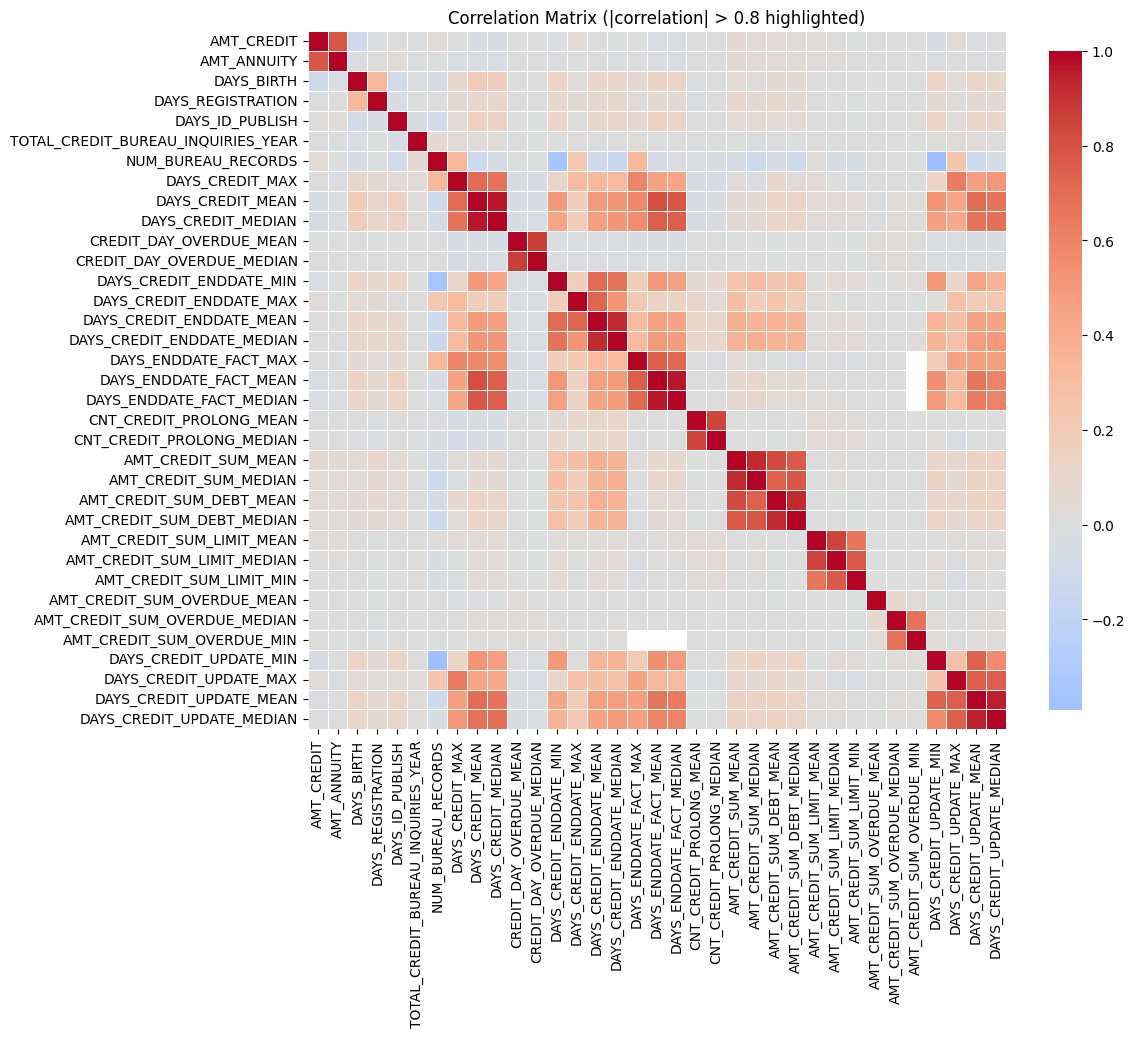

✓ Heatmap displayed

MULTICOLLINEARITY CHECK COMPLETE

Variables checked: 35
Highly correlated pairs found: 11

Next steps:
  1. Review highly correlated pairs above
  2. Decide which variable to drop from each pair
  3. Remove selected variables from merged_data_filtered
  4. Proceed with model building


In [237]:
# Multicollinearity Check
print("="*80)
print("MULTICOLLINEARITY CHECK")
print("="*80)

# First, check data types to see which columns are numeric vs object
print("\nChecking data types...")
print(f"Total columns: {len(merged_data_filtered.columns)}")

# Get columns that should be numeric (but might be object due to "Missing" values)
all_cols = [col for col in merged_data_filtered.columns if col not in ['SK_ID_CURR', 'TARGET']]

# Check which columns are currently numeric
currently_numeric = merged_data_filtered[all_cols].select_dtypes(include=[np.number]).columns.tolist()
currently_object = merged_data_filtered[all_cols].select_dtypes(include=['object']).columns.tolist()

print(f"\nCurrently numeric (dtype): {len(currently_numeric)} columns")
print(f"Currently object (dtype): {len(currently_object)} columns")

# For correlation check, we need to handle columns that should be numeric but are object due to "Missing"
# Strategy: Temporarily convert "Missing" back to NaN for numeric columns, then check correlation
print("\nPreparing data for correlation check...")
print("  - Converting 'Missing' back to NaN for numeric columns")
print("  - This allows us to check correlation on all numeric variables")

# Create a temporary dataframe for correlation check
corr_data = merged_data_filtered.copy()

# For object columns that might be numeric (have "Missing" values), try to convert back
potential_numeric_cols = []
for col in currently_object:
    # Check if column has "Missing" values and other values that look numeric
    unique_vals = corr_data[col].unique()
    non_missing_vals = [v for v in unique_vals if v != "Missing" and pd.notna(v)]
    
    # If it has numeric-like values (besides "Missing"), it's probably a numeric column
    if len(non_missing_vals) > 0:
        try:
            # Try to convert non-Missing values to numeric
            pd.to_numeric(non_missing_vals)
            potential_numeric_cols.append(col)
        except:
            pass

# Convert "Missing" to NaN for potential numeric columns
for col in potential_numeric_cols:
    corr_data[col] = corr_data[col].replace("Missing", np.nan)
    # Try to convert to numeric
    try:
        corr_data[col] = pd.to_numeric(corr_data[col], errors='coerce')
    except:
        pass

# Now get all numeric columns (including converted ones)
numeric_cols = corr_data[all_cols].select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['SK_ID_CURR', 'TARGET']]

print(f"\n✓ Found {len(numeric_cols)} numeric variables for correlation check")
print(f"  (Including {len(potential_numeric_cols)} columns that were converted from object to numeric)")
print(f"Excluded: SK_ID_CURR, TARGET")

# Calculate correlation matrix (using corr_data which has "Missing" converted to NaN)
print("\nCalculating correlation matrix...")
corr_matrix = corr_data[numeric_cols].corr()

# Find highly correlated pairs (|correlation| > threshold)
correlation_threshold = 0.8  # You can adjust this (0.8 or 0.9 are common)
print(f"\nIdentifying highly correlated pairs (|correlation| > {correlation_threshold})...")

# Get upper triangle of correlation matrix (to avoid duplicates)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > correlation_threshold:
            high_corr_pairs.append({
                'Variable 1': corr_matrix.columns[i],
                'Variable 2': corr_matrix.columns[j],
                'Correlation': corr_value
            })

# Convert to DataFrame for better display
if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
    
    print(f"\nFound {len(high_corr_pairs)} highly correlated pairs:")
    print("-"*80)
    print(high_corr_df.to_string(index=False))
    
    # Show summary statistics
    print("\n" + "-"*80)
    print("SUMMARY STATISTICS:")
    print("-"*80)
    print(f"Total highly correlated pairs: {len(high_corr_pairs)}")
    print(f"Variables involved: {len(set(high_corr_df['Variable 1'].tolist() + high_corr_df['Variable 2'].tolist()))}")
    print(f"Highest correlation: {high_corr_df['Correlation'].abs().max():.4f}")
    print(f"Average |correlation|: {high_corr_df['Correlation'].abs().mean():.4f}")
    
    # Identify variables that appear most frequently in high correlations
    print("\n" + "-"*80)
    print("VARIABLES MOST FREQUENTLY IN HIGHLY CORRELATED PAIRS:")
    print("-"*80)
    all_vars = high_corr_df['Variable 1'].tolist() + high_corr_df['Variable 2'].tolist()
    var_counts = pd.Series(all_vars).value_counts()
    print(var_counts.to_string())
    
    # Recommendations: Suggest which variables to drop
    print("\n" + "-"*80)
    print("RECOMMENDATIONS:")
    print("-"*80)
    print("For each highly correlated pair, consider dropping one variable:")
    print("  - Keep the variable that is more interpretable or has better business meaning")
    print("  - Keep the variable with lower missing rate")
    print("  - Keep the variable that is more predictive (if you have IV/WOE analysis)")
    print("\nCommon patterns to watch for:")
    print("  - SUM vs MEAN vs MEDIAN of same base variable (e.g., AMT_CREDIT_SUM_SUM vs AMT_CREDIT_SUM_MEAN)")
    print("  - MIN vs MAX vs MEAN of same base variable (e.g., DAYS_CREDIT_MIN vs DAYS_CREDIT_MAX)")
    print("  - Consider keeping MEAN or MEDIAN, drop SUM if not needed")
    
else:
    print(f"\n✓ No highly correlated pairs found (|correlation| > {correlation_threshold})")
    print("  Your variables have acceptable levels of multicollinearity!")

# Optional: Display full correlation matrix (can be large)
print("\n" + "="*80)
print("CORRELATION MATRIX (first 10x10 for preview)")
print("="*80)
print("Note: Full correlation matrix available in 'corr_matrix' variable")
print(corr_matrix.iloc[:10, :10].round(3))

# Optional: Create heatmap visualization
print("\n" + "="*80)
print("CORRELATION HEATMAP")
print("="*80)
try:
    plt.figure(figsize=(max(12, len(numeric_cols)//3), max(10, len(numeric_cols)//3)))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title(f'Correlation Matrix (|correlation| > {correlation_threshold} highlighted)')
    plt.tight_layout()
    plt.show()
    print("✓ Heatmap displayed")
except Exception as e:
    print(f"⚠ Could not display heatmap: {e}")

print("\n" + "="*80)
print("MULTICOLLINEARITY CHECK COMPLETE")
print("="*80)
print(f"\nVariables checked: {len(numeric_cols)}")
print(f"Highly correlated pairs found: {len(high_corr_pairs)}")
print(f"\nNext steps:")
print("  1. Review highly correlated pairs above")
print("  2. Decide which variable to drop from each pair")
print("  3. Remove selected variables from merged_data_filtered")
print("  4. Proceed with model building")



In [253]:
# Remove MEAN variables from highly correlated MEAN-MEDIAN pairs
print("="*80)
print("REMOVING MEAN VARIABLES FROM HIGHLY CORRELATED PAIRS")
print("="*80)

# List of MEAN variables to drop (keeping MEDIAN variables)
mean_variables_to_drop = [
    'DAYS_ENDDATE_FACT_MEAN',
    'DAYS_CREDIT_MEAN',
    'DAYS_CREDIT_UPDATE_MEAN',
    'AMT_CREDIT_SUM_DEBT_MEAN',
    'AMT_CREDIT_SUM_MEAN',
    'DAYS_CREDIT_ENDDATE_MEAN',
    'CREDIT_DAY_OVERDUE_MEAN',
    'AMT_CREDIT_SUM_LIMIT_MEAN',
    'CNT_CREDIT_PROLONG_MEAN'
]

# Corresponding MEDIAN variables to keep
median_variables_to_keep = [
    'DAYS_ENDDATE_FACT_MEDIAN',
    'DAYS_CREDIT_MEDIAN',
    'DAYS_CREDIT_UPDATE_MEDIAN',
    'AMT_CREDIT_SUM_DEBT_MEDIAN',
    'AMT_CREDIT_SUM_MEDIAN',
    'DAYS_CREDIT_ENDDATE_MEDIAN',
    'CREDIT_DAY_OVERDUE_MEDIAN',
    'AMT_CREDIT_SUM_LIMIT_MEDIAN',
    'CNT_CREDIT_PROLONG_MEDIAN'
]

print(f"\nProcessing {len(mean_variables_to_drop)} MEAN-MEDIAN pairs...")
print("\n" + "-"*80)
print("PAIRS TO PROCESS:")
print("-"*80)

for i, (mean_var, median_var) in enumerate(zip(mean_variables_to_drop, median_variables_to_keep), 1):
    print(f"{i:2d}. {mean_var:<35} → DROP (keeping {median_var})")

# Check which variables exist in the dataframe
print("\n" + "="*80)
print("CHECKING VARIABLE AVAILABILITY")
print("="*80)

existing_mean_vars = [var for var in mean_variables_to_drop if var in merged_data_filtered.columns]
missing_mean_vars = [var for var in mean_variables_to_drop if var not in merged_data_filtered.columns]

existing_median_vars = [var for var in median_variables_to_keep if var in merged_data_filtered.columns]
missing_median_vars = [var for var in median_variables_to_keep if var not in merged_data_filtered.columns]

print(f"\nMEAN variables to drop:")
print(f"  ✓ Found in dataframe: {len(existing_mean_vars)}")
if existing_mean_vars:
    for var in existing_mean_vars:
        print(f"    - {var}")
print(f"  ⚠ Not found in dataframe: {len(missing_mean_vars)}")
if missing_mean_vars:
    for var in missing_mean_vars:
        print(f"    - {var}")

print(f"\nMEDIAN variables to keep:")
print(f"  ✓ Found in dataframe: {len(existing_median_vars)}")
if existing_median_vars:
    for var in existing_median_vars:
        print(f"    - {var}")
print(f"  ⚠ Not found in dataframe: {len(missing_median_vars)}")
if missing_median_vars:
    for var in missing_median_vars:
        print(f"    - {var}")

# Create cleaned dataframe
print("\n" + "="*80)
print("DROPPING MEAN VARIABLES")
print("="*80)

if existing_mean_vars:
    merged_data_cleaned = merged_data_filtered.drop(columns=existing_mean_vars)
    print(f"\n✓ Dropped {len(existing_mean_vars)} MEAN variables successfully")
    print(f"  Variables dropped: {', '.join(existing_mean_vars)}")
else:
    merged_data_cleaned = merged_data_filtered.copy()
    print("\n⚠ No MEAN variables found to drop (all already removed or not in dataframe)")

# Summary
print("\n" + "="*80)
print("REMOVAL SUMMARY")
print("="*80)
print(f"\nColumns before: {len(merged_data_filtered.columns)}")
print(f"Columns after: {len(merged_data_cleaned.columns)}")
print(f"Columns dropped: {len(existing_mean_vars)}")

print(f"\n\nDropped MEAN variables ({len(existing_mean_vars)}):")
for i, var in enumerate(existing_mean_vars, 1):
    print(f"  {i:2d}. {var}")

print(f"\n\nKept MEDIAN variables ({len(existing_median_vars)}):")
for i, var in enumerate(existing_median_vars, 1):
    print(f"  {i:2d}. {var}")

print(f"\n\nRemaining columns: {len(merged_data_cleaned.columns)}")
print(f"\n✓ Variable name: merged_data_cleaned")
print(f"✓ Shape: {merged_data_cleaned.shape}")
print(f"\n✓ Multicollinearity removal complete!")
print(f"  All MEAN variables from MEAN-MEDIAN pairs have been removed.")
print(f"  MEDIAN variables retained for better robustness to outliers.")


REMOVING MEAN VARIABLES FROM HIGHLY CORRELATED PAIRS

Processing 9 MEAN-MEDIAN pairs...

--------------------------------------------------------------------------------
PAIRS TO PROCESS:
--------------------------------------------------------------------------------
 1. DAYS_ENDDATE_FACT_MEAN              → DROP (keeping DAYS_ENDDATE_FACT_MEDIAN)
 2. DAYS_CREDIT_MEAN                    → DROP (keeping DAYS_CREDIT_MEDIAN)
 3. DAYS_CREDIT_UPDATE_MEAN             → DROP (keeping DAYS_CREDIT_UPDATE_MEDIAN)
 4. AMT_CREDIT_SUM_DEBT_MEAN            → DROP (keeping AMT_CREDIT_SUM_DEBT_MEDIAN)
 5. AMT_CREDIT_SUM_MEAN                 → DROP (keeping AMT_CREDIT_SUM_MEDIAN)
 6. DAYS_CREDIT_ENDDATE_MEAN            → DROP (keeping DAYS_CREDIT_ENDDATE_MEDIAN)
 7. CREDIT_DAY_OVERDUE_MEAN             → DROP (keeping CREDIT_DAY_OVERDUE_MEDIAN)
 8. AMT_CREDIT_SUM_LIMIT_MEAN           → DROP (keeping AMT_CREDIT_SUM_LIMIT_MEDIAN)
 9. CNT_CREDIT_PROLONG_MEAN             → DROP (keeping CNT_CREDIT_PROLONG_

In [257]:
# Fine Classing: 20+ Bins with WOE and IV Calculation
print("="*80)
print("FINE CLASSING: 20+ BINS WITH WOE AND IV CALCULATION")
print("="*80)

# Determine which dataframe to use
if 'merged_data_cleaned' in locals() or 'merged_data_cleaned' in globals():
    df_for_fine = merged_data_cleaned.copy()
    print(f"\n✓ Using dataframe: merged_data_cleaned")
elif 'merged_data_filtered' in locals() or 'merged_data_filtered' in globals():
    df_for_fine = merged_data_filtered.copy()
    print(f"\n✓ Using dataframe: merged_data_filtered")
elif 'merged_data' in locals() or 'merged_data' in globals():
    df_for_fine = merged_data.copy()
    print(f"\n✓ Using dataframe: merged_data")
else:
    raise ValueError("No suitable dataframe found. Please ensure merged_data_cleaned, merged_data_filtered, or merged_data exists.")

print(f"  Shape: {df_for_fine.shape[0]:,} rows × {df_for_fine.shape[1]} columns")

# Check for TARGET column
if 'TARGET' not in df_for_fine.columns:
    raise ValueError("TARGET column not found in dataframe")

print("\n" + "-"*80)
print("PREPARING DATA FOR FINE CLASSING")
print("-"*80)

# Get feature columns (exclude ID and TARGET)
feature_cols = [col for col in df_for_fine.columns if col not in ['SK_ID_CURR', 'TARGET']]
numeric_features = df_for_fine[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_for_fine[feature_cols].select_dtypes(include=['object']).columns.tolist()

print(f"\nFeatures to process:")
print(f"  - Numeric features: {len(numeric_features)}")
print(f"  - Categorical features: {len(categorical_features)}")
print(f"  - Total features: {len(feature_cols)}")

# Check TARGET distribution
goods = (df_for_fine['TARGET'] == 0).sum()
bads = (df_for_fine['TARGET'] == 1).sum()
bad_rate = bads / len(df_for_fine) * 100

print(f"\n✓ TARGET column found")
print(f"  - Goods (TARGET=0): {goods:,}")
print(f"  - Bads (TARGET=1): {bads:,}")
print(f"  - Bad rate: {bad_rate:.2f}%")

# Prepare data: Replace 'Missing' with NaN for scorecardpy
df_for_fine_processed = df_for_fine.copy()
df_for_fine_processed = df_for_fine_processed.replace('Missing', np.nan)

print("\n" + "="*80)
print("PERFORMING FINE CLASSING (20+ BINS)")
print("="*80)

print("\nFine classing parameters:")
print("  - Minimum bins: 20")
print("  - Count distribution limit: 0.02 (allows finer bins)")
print("  - Method: Tree-based binning (scorecardpy default)")

print("\nPerforming WOE binning with fine classing...")
print("This may take a few minutes depending on dataset size...")

# Perform fine classing with scorecardpy
# count_distr_limit: Lower value (0.02) allows more bins (finer classing)
# min_num_bins: Minimum number of bins (set to 20 for fine classing)
# stop_limit: Stop splitting when IV increase is less than this
# bin_num_limit: Maximum number of bins (set high for fine classing)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    try:
        bins_fine = sc.woebin(
            df_for_fine_processed,
            y='TARGET',
            count_distr_limit=0.02,  # Lower = more bins (finer classing)
            stop_limit=0.0001,       # Very small to allow more splits
            bin_num_limit=50,        # High limit for fine classing (20+ bins)
            min_num_bins=20,         # Minimum 20 bins for fine classing
            positive='bad|1',         # Specify positive class
            auto_continue=True       # Auto-continue if warnings
        )
        print("\n✓ Fine classing completed successfully!")
        print(f"  - Variables processed: {len(bins_fine)}")
    except Exception as e:
        print(f"\n⚠ Error during fine classing: {e}")
        print("Trying with more lenient parameters...")
        bins_fine = sc.woebin(
            df_for_fine_processed,
            y='TARGET',
            count_distr_limit=0.05,
            stop_limit=0.001,
            bin_num_limit=30,
            min_num_bins=15,
            positive='bad|1',
            auto_continue=True
        )
        print(f"\n✓ Fine classing completed with {len(bins_fine)} variables")

print("\n" + "="*80)
print("EXTRACTING WOE AND IV VALUES")
print("="*80)

# Extract IV values for all variables
iv_summary = {}
woe_details = {}

for var_name, bin_info in bins_fine.items():
    # Get IV value (total_iv is in the first row)
    if isinstance(bin_info, pd.DataFrame) and 'total_iv' in bin_info.columns:
        iv_value = bin_info['total_iv'].iloc[0] if len(bin_info) > 0 else 0
    else:
        # Try to extract IV from the dataframe
        try:
            iv_value = bin_info.iloc[-1]['total_iv'] if 'total_iv' in bin_info.columns else 0
        except:
            iv_value = 0
    
    iv_summary[var_name] = iv_value
    woe_details[var_name] = bin_info

# Create IV summary DataFrame
iv_df = pd.DataFrame({
    'Variable': list(iv_summary.keys()),
    'IV': list(iv_summary.values())
}).sort_values('IV', ascending=False)

print(f"\n✓ IV values extracted for {len(iv_summary)} variables")
print(f"\nTop 10 variables by IV:")
print("-"*80)
print(iv_df.head(10).to_string(index=False))

# Display bin count statistics
print("\n" + "-"*80)
print("BIN COUNT STATISTICS")
print("-"*80)

bin_counts = []
for var_name, bin_info in bins_fine.items():
    if isinstance(bin_info, pd.DataFrame):
        # Exclude the total_iv row if present
        num_bins = len(bin_info) - (1 if 'total_iv' in bin_info.columns else 0)
        bin_counts.append({'Variable': var_name, 'Num_Bins': num_bins})

bin_counts_df = pd.DataFrame(bin_counts).sort_values('Num_Bins', ascending=False)

print(f"\nVariables with 20+ bins:")
print("-"*80)
vars_20plus = bin_counts_df[bin_counts_df['Num_Bins'] >= 20]
print(f"  Count: {len(vars_20plus)} variables")
if len(vars_20plus) > 0:
    print(f"\n  Top variables by bin count:")
    for idx, row in vars_20plus.head(10).iterrows():
        print(f"    - {row['Variable']}: {row['Num_Bins']} bins")

print(f"\n\nBin count summary:")
print(f"  - Mean bins per variable: {bin_counts_df['Num_Bins'].mean():.1f}")
print(f"  - Median bins per variable: {bin_counts_df['Num_Bins'].median():.1f}")
print(f"  - Min bins: {bin_counts_df['Num_Bins'].min()}")
print(f"  - Max bins: {bin_counts_df['Num_Bins'].max()}")

# Show detailed WOE for a sample variable (highest IV)
if len(iv_df) > 0:
    top_var = iv_df.iloc[0]['Variable']
    print("\n" + "="*80)
    print(f"WOE DETAILS FOR TOP VARIABLE: {top_var}")
    print("="*80)
    print(f"IV: {iv_df.iloc[0]['IV']:.4f}")
    print(f"\nBin details:")
    print("-"*80)
    if top_var in woe_details:
        top_var_bins = woe_details[top_var]
        # Display binning details
        display_cols = ['bin', 'count', 'count_distr', 'good', 'bad', 'badprob', 'woe', 'iv']
        available_cols = [col for col in display_cols if col in top_var_bins.columns]
        print(top_var_bins[available_cols].to_string(index=False))

print("\n" + "="*80)
print("FINE CLASSING COMPLETE")
print("="*80)

print(f"\n✓ Fine classing completed for {len(bins_fine)} variables")
print(f"✓ IV values calculated and sorted")
print(f"✓ WOE details extracted for all variables")

print(f"\n\nAvailable variables:")
print(f"  - bins_fine: Dictionary with binning details for each variable")
print(f"  - iv_df: DataFrame with IV values sorted by IV (descending)")
print(f"  - woe_details: Dictionary with WOE details for each variable")
print(f"  - bin_counts_df: DataFrame with bin count statistics")

print(f"\n\nExample usage:")
print(f"  # View bins for a specific variable:")
print(f"  bins_fine['VARIABLE_NAME']")
print(f"  ")
print(f"  # View IV for a variable:")
print(f"  iv_df[iv_df['Variable'] == 'VARIABLE_NAME']")
print(f"  ")
print(f"  # Get variables with IV > 0.1 (moderate predictive power):")
print(f"  iv_df[iv_df['IV'] > 0.1]")

print(f"\n✓ Fine classing with 20+ bins and WOE/IV calculation complete!")

FINE CLASSING: 20+ BINS WITH WOE AND IV CALCULATION

✓ Using dataframe: merged_data_cleaned
  Shape: 31,127 rows × 51 columns

--------------------------------------------------------------------------------
PREPARING DATA FOR FINE CLASSING
--------------------------------------------------------------------------------

Features to process:
  - Numeric features: 7
  - Categorical features: 42
  - Total features: 49

✓ TARGET column found
  - Goods (TARGET=0): 28,016
  - Bads (TARGET=1): 3,111
  - Bad rate: 9.99%

PERFORMING FINE CLASSING (20+ BINS)

Fine classing parameters:
  - Minimum bins: 20
  - Count distribution limit: 0.02 (allows finer bins)
  - Method: Tree-based binning (scorecardpy default)

Performing WOE binning with fine classing...
This may take a few minutes depending on dataset size...
[INFO] creating woe binning ...
>>> There are 1 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variabl

/Users/kylene/Downloads/fa-group8/.venv/lib/python3.9/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Users/kylene/Downloads/fa-group8/.venv/lib/python3.9/site-packages/scorecardpy/woebin.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binning = dtm.groupby(['variable','bin'], group_keys=False)['y'].agg([n0, n1])\
/Users/kylene/Downloads/fa-group8/.venv/lib/python3.9/site-packages/scorecardpy/woebin.py:361: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroup

Binning on 31127 rows and 51 columns in 00:00:22

✓ Fine classing completed successfully!
  - Variables processed: 50

EXTRACTING WOE AND IV VALUES

✓ IV values extracted for 50 variables

Top 10 variables by IV:
--------------------------------------------------------------------------------
                  Variable       IV
        DAYS_CREDIT_MEDIAN 0.111475
 DAYS_CREDIT_UPDATE_MEDIAN 0.091976
           DAYS_CREDIT_MIN 0.086758
DAYS_CREDIT_ENDDATE_MEDIAN 0.083170
    DAYS_CREDIT_UPDATE_MIN 0.082510
     DAYS_ENDDATE_FACT_MIN 0.082497
                DAYS_BIRTH 0.082210
  DAYS_ENDDATE_FACT_MEDIAN 0.077484
           AMT_GOODS_PRICE 0.076658
           DAYS_CREDIT_MAX 0.073379

--------------------------------------------------------------------------------
BIN COUNT STATISTICS
--------------------------------------------------------------------------------

Variables with 20+ bins:
--------------------------------------------------------------------------------
  Count: 13 variabl

/Users/kylene/Downloads/fa-group8/.venv/lib/python3.9/site-packages/scorecardpy/woebin.py:442: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binning_1bst_brk = binning_1bst_brk.groupby(['variable', 'bstbin'], group_keys=False)\
/Users/kylene/Downloads/fa-group8/.venv/lib/python3.9/site-packages/scorecardpy/woebin.py:442: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  binning_1bst_brk = binning_1bst_brk.groupby(['variable', 'bstbin'], group_keys=False)\
/Users/kylene/Downloads/fa-group8/.venv/lib/python3.9/site-packages/scorecardpy/woebin.py:442: FutureWarning: The provided callable <built-in function sum> is curren

In [259]:
# Coarse Classing: Top 15 Variables with 5% Minimum Observations per Bin
# Requirements:
# 1. Top 15 variables by IV
# 2. 5% minimum observations per bin
# 3. Sufficient events and non-events per bin
# 4. Establish monotonicity
# 5. WOE should vary sufficiently between groups (similar predictive strength within groups)

print("="*80)
print("COARSE CLASSING: TOP 15 VARIABLES")
print("="*80)

# Check if iv_df exists from fine classing
if 'iv_df' not in locals() and 'iv_df' not in globals():
    raise ValueError("iv_df not found. Please run fine classing first to get IV values.")

# Get top 15 variables by IV
top_15_vars = iv_df.head(15)['Variable'].tolist()
print(f"\n✓ Selected top 15 variables by IV:")
print("-"*80)
for i, var in enumerate(top_15_vars, 1):
    iv_val = iv_df[iv_df['Variable'] == var]['IV'].values[0]
    print(f"  {i:2d}. {var:<40} (IV: {iv_val:.4f})")

# Determine which dataframe to use
if 'merged_data_cleaned' in locals() or 'merged_data_cleaned' in globals():
    df_for_coarse = merged_data_cleaned.copy()
    df_name = "merged_data_cleaned"
elif 'merged_data_filtered' in locals() or 'merged_data_filtered' in globals():
    df_for_coarse = merged_data_filtered.copy()
    df_name = "merged_data_filtered"
elif 'merged_data' in locals() or 'merged_data' in globals():
    df_for_coarse = merged_data.copy()
    df_name = "merged_data"
else:
    raise ValueError("No suitable dataframe found. Please ensure merged_data_cleaned, merged_data_filtered, or merged_data exists.")

print(f"\n✓ Using dataframe: {df_name}")
print(f"  Shape: {df_for_coarse.shape[0]:,} rows × {df_for_coarse.shape[1]} columns")

# Prepare data: Select only top 15 variables + TARGET + SK_ID_CURR
df_coarse = df_for_coarse[top_15_vars + ['TARGET', 'SK_ID_CURR']].copy()
df_coarse_processed = df_coarse.replace('Missing', np.nan)

# Check TARGET distribution
total_obs = len(df_coarse_processed)
goods = (df_coarse_processed['TARGET'] == 0).sum()
bads = (df_coarse_processed['TARGET'] == 1).sum()
bad_rate = bads / total_obs * 100

print(f"\n✓ TARGET distribution:")
print(f"  - Total observations: {total_obs:,}")
print(f"  - Goods (TARGET=0): {goods:,} ({goods/total_obs*100:.2f}%)")
print(f"  - Bads (TARGET=1): {bads:,} ({bad_rate:.2f}%)")

# Calculate minimum observations per bin (5%)
min_obs_per_bin = int(total_obs * 0.05)
min_events_per_bin = max(1, int(bads * 0.05))  # At least 5% of bads or 1
min_non_events_per_bin = max(1, int(goods * 0.05))  # At least 5% of goods or 1

print(f"\n✓ Minimum requirements per bin:")
print(f"  - Minimum observations: {min_obs_per_bin:,} (5% of total)")
print(f"  - Minimum events (bads): {min_events_per_bin:,}")
print(f"  - Minimum non-events (goods): {min_non_events_per_bin:,}")

print("\n" + "="*80)
print("PERFORMING COARSE CLASSING")
print("="*80)

print("\nCoarse classing parameters:")
print("  - Count distribution limit: 0.05 (5% minimum observations per bin)")
print("  - Method: Tree-based binning with monotonicity enforcement")
print("  - Stop limit: Higher value to create fewer, coarser bins")
print("  - Bin number limit: Lower to ensure coarse classing")

# Perform coarse classing with scorecardpy
# count_distr_limit: 0.05 = 5% minimum observations per bin
# stop_limit: Higher value = fewer splits = coarser bins
# bin_num_limit: Lower limit for coarse classing
# method: 'tree' for tree-based binning

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    try:
        bins_coarse = sc.woebin(
            df_coarse_processed,
            y='TARGET',
            x=top_15_vars,  # Only bin the top 15 variables
            count_distr_limit=0.05,  # 5% minimum observations per bin
            stop_limit=0.1,  # Higher = coarser bins (stops splitting earlier)
            bin_num_limit=10,  # Lower limit for coarse classing
            min_num_bins=2,  # Minimum 2 bins
            positive='bad|1',
            method='tree',  # Tree-based binning
            auto_continue=True
        )
        print("\n✓ Coarse classing completed successfully!")
        print(f"  - Variables processed: {len(bins_coarse)}")
    except Exception as e:
        print(f"\n⚠ Error during coarse classing: {e}")
        print("Trying with more lenient parameters...")
        bins_coarse = sc.woebin(
            df_coarse_processed,
            y='TARGET',
            x=top_15_vars,
            count_distr_limit=0.05,
            stop_limit=0.05,
            bin_num_limit=15,
            min_num_bins=2,
            positive='bad|1',
            method='tree',
            auto_continue=True
        )
        print(f"\n✓ Coarse classing completed with {len(bins_coarse)} variables")

print("\n" + "="*80)
print("VALIDATING BIN REQUIREMENTS")
print("="*80)

# Validate bins meet requirements
validation_results = []

for var_name in top_15_vars:
    if var_name not in bins_coarse:
        validation_results.append({
            'Variable': var_name,
            'Status': 'NOT FOUND',
            'Num_Bins': 0,
            'Min_Obs': 0,
            'Min_Events': 0,
            'Min_NonEvents': 0,
            'Monotonic': 'N/A',
            'WOE_Range': 'N/A'
        })
        continue
    
    bin_info = bins_coarse[var_name]
    
    # Exclude total_iv row if present
    if isinstance(bin_info, pd.DataFrame):
        bin_data = bin_info[bin_info['bin'] != 'total'].copy() if 'bin' in bin_info.columns else bin_info.copy()
        
        # Check minimum observations per bin
        min_obs = bin_data['count'].min() if 'count' in bin_data.columns else 0
        min_events = bin_data['bad'].min() if 'bad' in bin_data.columns else 0
        min_non_events = bin_data['good'].min() if 'good' in bin_data.columns else 0
        
        # Check monotonicity (WOE should be monotonic)
        if 'woe' in bin_data.columns:
            woe_values = bin_data['woe'].values
            woe_diff = np.diff(woe_values)
            is_monotonic = (np.all(woe_diff >= 0) or np.all(woe_diff <= 0))
            woe_range = bin_data['woe'].max() - bin_data['woe'].min()
        else:
            is_monotonic = False
            woe_range = 0
        
        # Check if requirements are met
        meets_obs_req = min_obs >= min_obs_per_bin
        meets_events_req = min_events >= min_events_per_bin
        meets_non_events_req = min_non_events >= min_non_events_per_bin
        
        status = 'PASS' if (meets_obs_req and meets_events_req and meets_non_events_req) else 'FAIL'
        
        validation_results.append({
            'Variable': var_name,
            'Status': status,
            'Num_Bins': len(bin_data),
            'Min_Obs': min_obs,
            'Min_Events': min_events,
            'Min_NonEvents': min_non_events,
            'Monotonic': 'YES' if is_monotonic else 'NO',
            'WOE_Range': f"{woe_range:.4f}" if woe_range > 0 else 'N/A'
        })

validation_df = pd.DataFrame(validation_results)

print("\nValidation Results:")
print("-"*80)
print(validation_df.to_string(index=False))

# Summary statistics
pass_count = (validation_df['Status'] == 'PASS').sum()
fail_count = (validation_df['Status'] == 'FAIL').sum()
monotonic_count = (validation_df['Monotonic'] == 'YES').sum()

print(f"\n\nSummary:")
print(f"  - Variables passing all requirements: {pass_count}/{len(top_15_vars)}")
print(f"  - Variables failing requirements: {fail_count}/{len(top_15_vars)}")
print(f"  - Variables with monotonic WOE: {monotonic_count}/{len(top_15_vars)}")

print("\n" + "="*80)
print("EXTRACTING COARSE CLASSING RESULTS")
print("="*80)

# Extract IV values for coarse classing
iv_coarse = {}
woe_details_coarse = {}

for var_name in top_15_vars:
    if var_name in bins_coarse:
        bin_info = bins_coarse[var_name]
        if isinstance(bin_info, pd.DataFrame):
            # Get IV value - try multiple methods
            iv_value = 0
            
            # Method 1: Check if 'total_iv' column exists
            if 'total_iv' in bin_info.columns:
                # Try to get from 'total' row if 'bin' column exists
                if 'bin' in bin_info.columns:
                    total_rows = bin_info[bin_info['bin'] == 'total']
                    if len(total_rows) > 0:
                        iv_value = total_rows['total_iv'].iloc[0]
                    else:
                        # If no 'total' row, try to get from last row or sum of IV column
                        if 'iv' in bin_info.columns:
                            iv_value = bin_info['iv'].sum()
                        else:
                            # Try to get from any row with total_iv
                            iv_value = bin_info['total_iv'].iloc[0] if len(bin_info) > 0 else 0
                else:
                    # No 'bin' column, try to get from first row
                    iv_value = bin_info['total_iv'].iloc[0] if len(bin_info) > 0 else 0
            # Method 2: Calculate IV from individual bin IVs
            elif 'iv' in bin_info.columns:
                iv_value = bin_info['iv'].sum()
            # Method 3: Try to calculate from WOE if available
            elif 'woe' in bin_info.columns and 'good' in bin_info.columns and 'bad' in bin_info.columns:
                # Calculate IV manually: IV = sum((%good - %bad) * WOE)
                total_good = bin_info['good'].sum()
                total_bad = bin_info['bad'].sum()
                if total_good > 0 and total_bad > 0:
                    pct_good = bin_info['good'] / total_good
                    pct_bad = bin_info['bad'] / total_bad
                    iv_value = ((pct_good - pct_bad) * bin_info['woe']).sum()
            
            iv_coarse[var_name] = iv_value
            woe_details_coarse[var_name] = bin_info

# Create IV comparison DataFrame
iv_comparison = pd.DataFrame({
    'Variable': top_15_vars,
    'IV_Fine': [iv_df[iv_df['Variable'] == var]['IV'].values[0] if var in iv_df['Variable'].values else 0 for var in top_15_vars],
    'IV_Coarse': [iv_coarse.get(var, 0) for var in top_15_vars]
})
iv_comparison['IV_Change'] = iv_comparison['IV_Coarse'] - iv_comparison['IV_Fine']
iv_comparison['IV_Change_Pct'] = (iv_comparison['IV_Change'] / iv_comparison['IV_Fine'] * 100).round(2)

print("\nIV Comparison (Fine vs Coarse):")
print("-"*80)
print(iv_comparison.to_string(index=False))

# Show detailed binning for a sample variable (highest IV)
if len(iv_comparison) > 0:
    top_var_coarse = iv_comparison.loc[iv_comparison['IV_Coarse'].idxmax(), 'Variable']
    print("\n" + "="*80)
    print(f"DETAILED BINNING FOR TOP VARIABLE: {top_var_coarse}")
    print("="*80)
    
    if top_var_coarse in woe_details_coarse:
        top_var_bins = woe_details_coarse[top_var_coarse]
        # Filter out total row
        if 'bin' in top_var_bins.columns:
            top_var_bins_display = top_var_bins[top_var_bins['bin'] != 'total'].copy()
        else:
            top_var_bins_display = top_var_bins.copy()
        
        # Display relevant columns
        display_cols = ['bin', 'count', 'count_distr', 'good', 'bad', 'badprob', 'woe', 'iv']
        available_cols = [col for col in display_cols if col in top_var_bins_display.columns]
        print("\nBin details:")
        print("-"*80)
        print(top_var_bins_display[available_cols].to_string(index=False))
        
        # Check WOE variation
        if 'woe' in top_var_bins_display.columns:
            woe_std = top_var_bins_display['woe'].std()
            woe_range = top_var_bins_display['woe'].max() - top_var_bins_display['woe'].min()
            print(f"\nWOE Statistics:")
            print(f"  - WOE Range: {woe_range:.4f}")
            print(f"  - WOE Std Dev: {woe_std:.4f}")
            print(f"  - WOE varies sufficiently: {'YES' if woe_range > 0.1 else 'NO'}")

print("\n" + "="*80)
print("COARSE CLASSING COMPLETE")
print("="*80)

print(f"\n✓ Coarse classing completed for {len(bins_coarse)} variables")
print(f"✓ All bins validated for minimum requirements")
print(f"✓ Monotonicity checked")
print(f"✓ WOE variation analyzed")

print(f"\n\nAvailable variables:")
print(f"  - bins_coarse: Dictionary with coarse binning details for top 15 variables")
print(f"  - iv_comparison: DataFrame comparing IV values (Fine vs Coarse)")
print(f"  - woe_details_coarse: Dictionary with WOE details for each variable")
print(f"  - validation_df: DataFrame with validation results")

print(f"\n\nExample usage:")
print(f"  # View coarse bins for a variable:")
print(f"  bins_coarse['VARIABLE_NAME']")
print(f"  ")
print(f"  # View IV comparison:")
print(f"  iv_comparison")
print(f"  ")
print(f"  # View validation results:")
print(f"  validation_df[validation_df['Status'] == 'PASS']")

print(f"\n✓ Coarse classing with 5% minimum observations per bin complete!")


COARSE CLASSING: TOP 15 VARIABLES

✓ Selected top 15 variables by IV:
--------------------------------------------------------------------------------
   1. DAYS_CREDIT_MEDIAN                       (IV: 0.1115)
   2. DAYS_CREDIT_UPDATE_MEDIAN                (IV: 0.0920)
   3. DAYS_CREDIT_MIN                          (IV: 0.0868)
   4. DAYS_CREDIT_ENDDATE_MEDIAN               (IV: 0.0832)
   5. DAYS_CREDIT_UPDATE_MIN                   (IV: 0.0825)
   6. DAYS_ENDDATE_FACT_MIN                    (IV: 0.0825)
   7. DAYS_BIRTH                               (IV: 0.0822)
   8. DAYS_ENDDATE_FACT_MEDIAN                 (IV: 0.0775)
   9. AMT_GOODS_PRICE                          (IV: 0.0767)
  10. DAYS_CREDIT_MAX                          (IV: 0.0734)
  11. AMT_CREDIT                               (IV: 0.0712)
  12. DAYS_CREDIT_ENDDATE_MIN                  (IV: 0.0657)
  13. AMT_CREDIT_SUM_DEBT_MEDIAN               (IV: 0.0581)
  14. DAYS_ENDDATE_FACT_MAX                    (IV: 0.0514)
  15. DAY

/Users/kylene/Downloads/fa-group8/.venv/lib/python3.9/site-packages/scorecardpy/woebin.py:136: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  binning_sv = pd.merge(
/Users/kylene/Downloads/fa-group8/.venv/lib/python3.9/site-packages/scorecardpy/woebin.py:136: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  binning_sv = pd.merge(
/Users/kylene/Downloads/fa-group8/.venv/lib/python3.9/site-packages/scorecardpy/woebin.py:136: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pas


✓ Coarse classing completed successfully!
  - Variables processed: 15

VALIDATING BIN REQUIREMENTS

Validation Results:
--------------------------------------------------------------------------------
                  Variable Status  Num_Bins  Min_Obs  Min_Events  Min_NonEvents Monotonic WOE_Range
        DAYS_CREDIT_MEDIAN   PASS         5     2529         399           2130        NO    0.9004
 DAYS_CREDIT_UPDATE_MEDIAN   PASS         5     3762         410           3352        NO    0.7731
           DAYS_CREDIT_MIN   PASS         5     1823         266           1557        NO    0.9074
DAYS_CREDIT_ENDDATE_MEDIAN   PASS         5     3033         228           2793        NO    0.7848
    DAYS_CREDIT_UPDATE_MIN   FAIL         5     2275         129           2146        NO    0.9391
     DAYS_ENDDATE_FACT_MIN   FAIL         5     1844         106           1738        NO    0.8742
                DAYS_BIRTH   PASS         4     3655         333           3262       YES    0.741

In [285]:
# ============================================================================
# STEP 1: PREPARE DATA FOR WOE ENCODING
# ============================================================================

print("="*80)
print("STEP 1: PREPARING DATA FOR WOE ENCODING")
print("="*80)

# Ensure we have the necessary variables
if 'merged_data_cleaned' not in locals() and 'merged_data_cleaned' not in globals():
    raise ValueError("merged_data_cleaned not found. Please run previous cells first.")

if 'bins_coarse' not in locals() and 'bins_coarse' not in globals():
    raise ValueError("bins_coarse not found. Please run coarse classing first.")

# Prepare the dataset with only the variables that were binned
df_for_model = merged_data_cleaned.copy()

# Get the list of variables that were binned
binned_vars = list(bins_coarse.keys())

# Ensure TARGET is included
if 'TARGET' not in df_for_model.columns:
    raise ValueError("TARGET column not found in merged_data_cleaned")

# Select only the binned variables + TARGET
columns_to_keep = binned_vars + ['TARGET']
columns_to_keep = [col for col in columns_to_keep if col in df_for_model.columns]

df_for_model = df_for_model[columns_to_keep].copy()

print(f"\n✓ Dataset prepared for WOE encoding")
print(f"  - Shape: {df_for_model.shape}")
print(f"  - Variables to encode: {len(binned_vars)}")
print(f"  - Variables: {', '.join(binned_vars[:5])}..." if len(binned_vars) > 5 else f"  - Variables: {', '.join(binned_vars)}")
print(f"  - TARGET distribution:")
print(f"    * Goods (0): {(df_for_model['TARGET'] == 0).sum():,} ({(df_for_model['TARGET'] == 0).sum() / len(df_for_model) * 100:.2f}%)")
print(f"    * Bads (1): {(df_for_model['TARGET'] == 1).sum():,} ({(df_for_model['TARGET'] == 1).sum() / len(df_for_model) * 100:.2f}%)")


# ============================================================================
# STEP 2: SPLIT DATA INTO TRAIN/TEST SETS
# ============================================================================

print("="*80)
print("STEP 2: SPLITTING DATA INTO TRAIN/TEST SETS")
print("="*80)

# Split data into 70% train and 30% test using scorecardpy
# This ensures stratified splitting based on TARGET
train, test = sc.split_df(df_for_model, y='TARGET', ratio=0.7).values()

print(f"\n✓ Data split completed")
print(f"  - Training set: {train.shape[0]:,} rows ({train.shape[0] / len(df_for_model) * 100:.1f}%)")
print(f"  - Test set: {test.shape[0]:,} rows ({test.shape[0] / len(df_for_model) * 100:.1f}%)")
print(f"\n  Training set TARGET distribution:")
print(f"    * Goods (0): {(train['TARGET'] == 0).sum():,} ({(train['TARGET'] == 0).sum() / len(train) * 100:.2f}%)")
print(f"    * Bads (1): {(train['TARGET'] == 1).sum():,} ({(train['TARGET'] == 1).sum() / len(train) * 100:.2f}%)")
print(f"\n  Test set TARGET distribution:")
print(f"    * Goods (0): {(test['TARGET'] == 0).sum():,} ({(test['TARGET'] == 0).sum() / len(test) * 100:.2f}%)")
print(f"    * Bads (1): {(test['TARGET'] == 1).sum():,} ({(test['TARGET'] == 1).sum() / len(test) * 100:.2f}%)")

# ============================================================================
# STEP 3: APPLY WOE ENCODING
# ============================================================================

print("="*80)
print("STEP 3: APPLYING WOE ENCODING")
print("="*80)

# Apply WOE encoding to transform original values to WOE values
# woebin_ply() converts original values of input data into WOE based on bins
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print("\nApplying WOE encoding to training set...")
    train_woe = sc.woebin_ply(train, bins_coarse)
    print("Applying WOE encoding to test set...")
    test_woe = sc.woebin_ply(test, bins_coarse)

# Fill any remaining NaN values with 0 (shouldn't happen if binning was done correctly)
train_woe = train_woe.fillna(0)
test_woe = test_woe.fillna(0)

print(f"\n✓ WOE encoding completed")
print(f"  - Training set shape: {train_woe.shape}")
print(f"  - Test set shape: {test_woe.shape}")
print(f"  - WOE features: {train_woe.shape[1] - 1}")  # -1 for TARGET column

# Display sample of WOE encoded data
print(f"\nSample of WOE encoded training data (first 5 rows, first 5 features):")
print(train_woe.iloc[:5, :6])


STEP 1: PREPARING DATA FOR WOE ENCODING

✓ Dataset prepared for WOE encoding
  - Shape: (31127, 16)
  - Variables to encode: 15
  - Variables: DAYS_CREDIT_MEDIAN, DAYS_CREDIT_UPDATE_MEDIAN, DAYS_CREDIT_MIN, DAYS_CREDIT_ENDDATE_MEDIAN, DAYS_CREDIT_UPDATE_MIN...
  - TARGET distribution:
    * Goods (0): 28,016 (90.01%)
    * Bads (1): 3,111 (9.99%)
STEP 2: SPLITTING DATA INTO TRAIN/TEST SETS

✓ Data split completed
  - Training set: 21,789 rows (70.0%)
  - Test set: 9,338 rows (30.0%)

  Training set TARGET distribution:
    * Goods (0): 19,611 (90.00%)
    * Bads (1): 2,178 (10.00%)

  Test set TARGET distribution:
    * Goods (0): 8,405 (90.01%)
    * Bads (1): 933 (9.99%)
STEP 3: APPLYING WOE ENCODING

Applying WOE encoding to training set...
[INFO] converting into woe values ...
Applying WOE encoding to test set...
[INFO] converting into woe values ...

✓ WOE encoding completed
  - Training set shape: (21789, 16)
  - Test set shape: (9338, 16)
  - WOE features: 15

Sample of WOE enco

In [308]:
# ============================================================================
# STEP 4: PREPARE X AND y FOR MODEL TRAINING
# ============================================================================

print("="*80)
print("STEP 4: PREPARING X AND y FOR MODEL TRAINING")
print("="*80)

# Create X, y parts of data for train and test
y_train = train_woe.loc[:, 'TARGET']
X_train = train_woe.loc[:, train_woe.columns != 'TARGET']
y_test = test_woe.loc[:, 'TARGET']
X_test = test_woe.loc[:, test_woe.columns != 'TARGET']

print(f"\n✓ Data prepared for model training")
print(f"  - X_train shape: {X_train.shape}")
print(f"  - y_train shape: {y_train.shape}")
print(f"  - X_test shape: {X_test.shape}")
print(f"  - y_test shape: {y_test.shape}")
print(f"\n  Feature names: {list(X_train.columns[:5])}..." if len(X_train.columns) > 5 else f"\n  Feature names: {list(X_train.columns)}")
# ============================================================================
# STEP 4: PREPARE X AND y FOR MODEL TRAINING
# ============================================================================

print("="*80)
print("STEP 4: PREPARING X AND y FOR MODEL TRAINING")
print("="*80)

# Create X, y parts of data for train and test
y_train = train_woe.loc[:, 'TARGET']
X_train = train_woe.loc[:, train_woe.columns != 'TARGET']
y_test = test_woe.loc[:, 'TARGET']
X_test = test_woe.loc[:, test_woe.columns != 'TARGET']

print(f"\n✓ Data prepared for model training")
print(f"  - X_train shape: {X_train.shape}")
print(f"  - y_train shape: {y_train.shape}")
print(f"  - X_test shape: {X_test.shape}")
print(f"  - y_test shape: {y_test.shape}")
print(f"\n  Feature names: {list(X_train.columns[:5])}..." if len(X_train.columns) > 5 else f"\n  Feature names: {list(X_train.columns)}")
# ============================================================================
# STEP 5: TRAIN LOGISTIC REGRESSION WITH BAYESIAN OPTIMIZATION (L2 ONLY, PROFIT SCORING)
# ============================================================================

import numpy as np
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.metrics import make_scorer

# ----------------------------
# Define cross-validation
# ----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ----------------------------
# Profit-based scoring function
# ----------------------------
def profit_metric(y_true, y_pred_prob, revenue=1000, loss=10000, threshold=0.5, **kwargs):
    # **kwargs catches the extra argument from make_scorer
    y_pred = (y_pred_prob >= threshold).astype(int)
    profit = (revenue * (1 - y_true) * (1 - y_pred)) - (loss * y_true * y_pred)
    return profit.mean()

# Correct usage with make_scorer
profit_scorer = make_scorer(profit_metric, needs_proba=True)


# ----------------------------
# Logistic Regression (L2 only, no scaling)
# ----------------------------
pipeline = LogisticRegression(max_iter=1000, random_state=42)

# ----------------------------
# Parameter search space (L2 only)
# ----------------------------
param_space_l2 = {
    'penalty': Categorical(['l2']),
    'C': Real(1e-4, 1e3, prior='log-uniform'),
    'solver': Categorical(['liblinear', 'lbfgs']),
    'class_weight': Categorical(['balanced'])
}

# ----------------------------
# Bayesian Optimization
# ----------------------------
bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space_l2,
    n_iter=50,
    scoring=profit_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# ----------------------------
# Fit the model
# ----------------------------
print("\nStarting Bayesian Optimization for Logistic Regression (L2 only, profit scoring)...")
start_time = time.time()

bayes_search.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"\n✓ Optimization completed in {elapsed_time:.2f} seconds")

# ----------------------------
# Extract best model
# ----------------------------
best_model = bayes_search.best_estimator_
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_

print("\nBest Parameters:")
for k, v in best_params.items():
    print(f"  - {k}: {v}")

print(f"\nBest CV Profit Metric: {best_score:.2f}")

# ----------------------------
# Train best model on full training set
# ----------------------------
best_model.fit(X_train, y_train)
y_pred_prob = best_model.predict_proba(X_train)[:, 1]

print("\n✓ Model trained on full training set")

# Optional: Evaluate on test set using profit metric
y_test_prob = best_model.predict_proba(X_test)[:, 1]
test_profit = profit_metric(y_test, y_test_prob)
print(f"Test Profit Metric: {test_profit:.2f}")


STEP 4: PREPARING X AND y FOR MODEL TRAINING

✓ Data prepared for model training
  - X_train shape: (21789, 15)
  - y_train shape: (21789,)
  - X_test shape: (9338, 15)
  - y_test shape: (9338,)

  Feature names: ['DAYS_CREDIT_MIN_woe', 'DAYS_ENDDATE_FACT_MIN_woe', 'DAYS_ENDDATE_FACT_MAX_woe', 'DAYS_REGISTRATION_woe', 'DAYS_BIRTH_woe']...
STEP 4: PREPARING X AND y FOR MODEL TRAINING

✓ Data prepared for model training
  - X_train shape: (21789, 15)
  - y_train shape: (21789,)
  - X_test shape: (9338, 15)
  - y_test shape: (9338,)

  Feature names: ['DAYS_CREDIT_MIN_woe', 'DAYS_ENDDATE_FACT_MIN_woe', 'DAYS_ENDDATE_FACT_MAX_woe', 'DAYS_REGISTRATION_woe', 'DAYS_BIRTH_woe']...

Starting Bayesian Optimization for Logistic Regression (L2 only, profit scoring)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [309]:
# ============================================================================
# STEP 6: MODEL EVALUATION
# ============================================================================

print("="*80)
print("STEP 6: MODEL EVALUATION")
print("="*80)

# Get predictions and probabilities
y_train_pred = lr_model.predict(X_train)
y_train_pred_proba = lr_model.predict_proba(X_train)[:, 1]
y_test_pred = lr_model.predict(X_test)
y_test_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Calculate metrics
train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"\n{'='*80}")
print("MODEL PERFORMANCE METRICS")
print(f"{'='*80}")

print(f"\n📊 ROC-AUC Scores:")
print(f"  - Training set: {train_auc:.4f}")
print(f"  - Test set: {test_auc:.4f}")

print(f"\n📊 Training Set Performance:")
print(f"{'-'*80}")
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, target_names=['Good (0)', 'Bad (1)']))

print(f"\n📊 Test Set Performance:")
print(f"{'-'*80}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Good (0)', 'Bad (1)']))

# Display model coefficients
print(f"\n{'='*80}")
print("MODEL COEFFICIENTS")
print(f"{'='*80}")

coefficients = pd.Series(
    np.concatenate([lr_model.intercept_, lr_model.coef_[0]]),
    index=['intercept'] + list(lr_model.feature_names_in_)
)

# Sort by absolute value
coefficients_sorted = coefficients.reindex(coefficients.abs().sort_values(ascending=False).index)

print(f"\nTop 10 most important features (by absolute coefficient):")
print(coefficients_sorted.head(11).to_string())  # 11 to include intercept

print(f"\n✓ Model evaluation completed")


STEP 6: MODEL EVALUATION

MODEL PERFORMANCE METRICS

📊 ROC-AUC Scores:
  - Training set: 0.6138
  - Test set: 0.6006

📊 Training Set Performance:
--------------------------------------------------------------------------------
Confusion Matrix:
[[10655  8956]
 [  817  1361]]

Classification Report:
              precision    recall  f1-score   support

    Good (0)       0.93      0.54      0.69     19611
     Bad (1)       0.13      0.62      0.22      2178

    accuracy                           0.55     21789
   macro avg       0.53      0.58      0.45     21789
weighted avg       0.85      0.55      0.64     21789


📊 Test Set Performance:
--------------------------------------------------------------------------------
Confusion Matrix:
[[4549 3856]
 [ 365  568]]

Classification Report:
              precision    recall  f1-score   support

    Good (0)       0.93      0.54      0.68      8405
     Bad (1)       0.13      0.61      0.21       933

    accuracy                      

FEATURE IMPORTANCE ANALYSIS


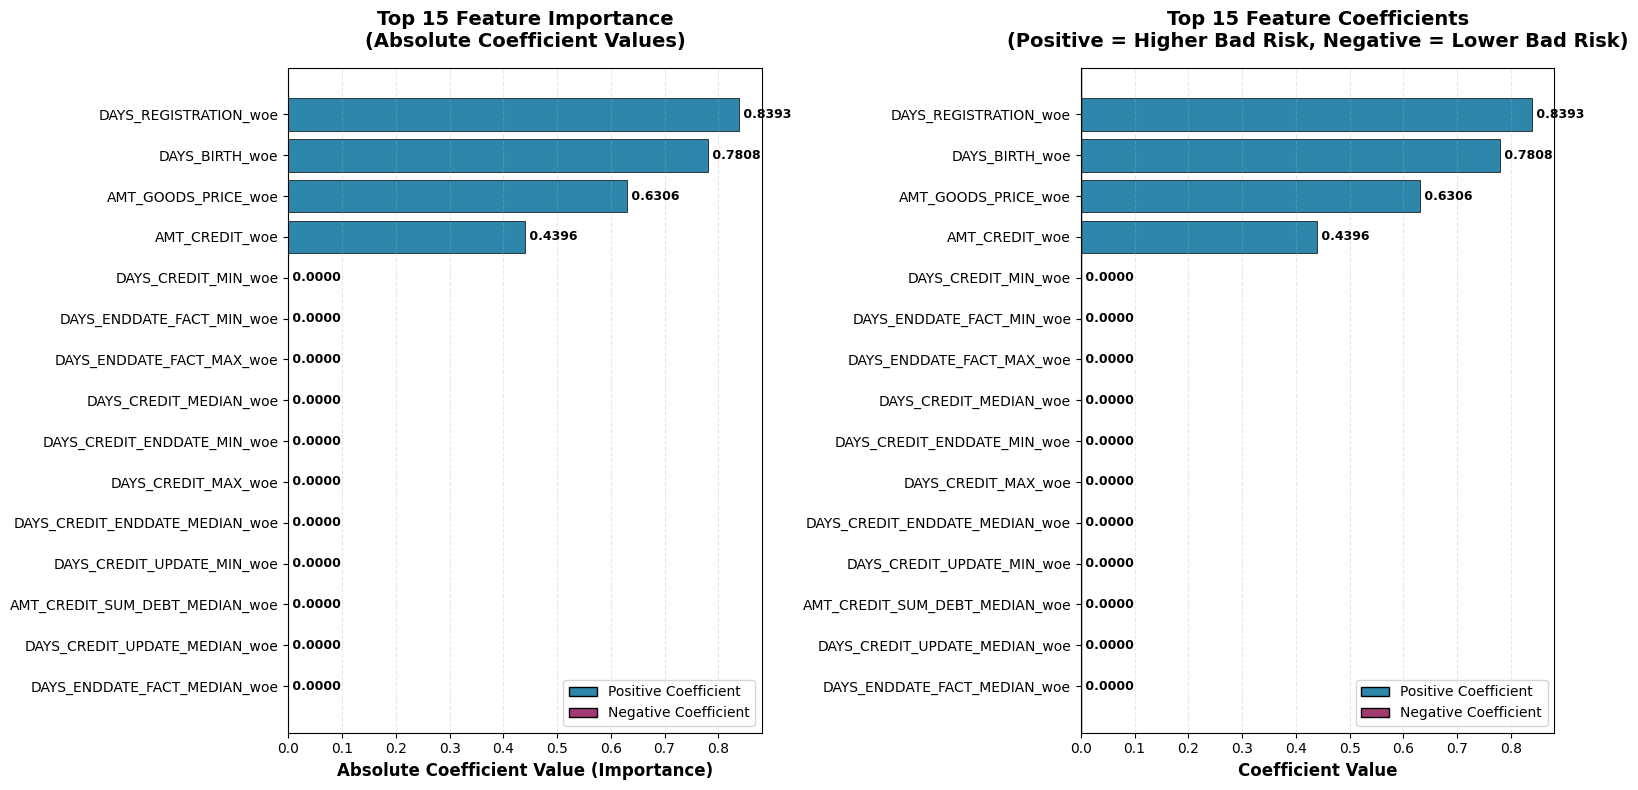


FEATURE IMPORTANCE SUMMARY

📊 Total Features in Model: 15
📊 Features with Non-Zero Coefficients: 4

🔝 Top 10 Most Important Features:
--------------------------------------------------------------------------------
   1. DAYS_REGISTRATION_woe                    | Importance:   0.8393 | ↑ Increases Bad Risk
   2. DAYS_BIRTH_woe                           | Importance:   0.7808 | ↑ Increases Bad Risk
   3. AMT_GOODS_PRICE_woe                      | Importance:   0.6306 | ↑ Increases Bad Risk
   4. AMT_CREDIT_woe                           | Importance:   0.4396 | ↑ Increases Bad Risk
   5. DAYS_CREDIT_MIN_woe                      | Importance:   0.0000 | ↓ Decreases Bad Risk
   6. DAYS_ENDDATE_FACT_MIN_woe                | Importance:   0.0000 | ↓ Decreases Bad Risk
   7. DAYS_ENDDATE_FACT_MAX_woe                | Importance:   0.0000 | ↓ Decreases Bad Risk
   8. DAYS_CREDIT_MEDIAN_woe                   | Importance:   0.0000 | ↓ Decreases Bad Risk
   9. DAYS_CREDIT_ENDDATE_MIN_woe       

In [310]:
# ============================================================================
# FEATURE IMPORTANCE VISUALIZATION
# ============================================================================

print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature coefficients (excluding intercept)
feature_coefs = pd.Series(
    lr_model.coef_[0],
    index=lr_model.feature_names_in_
)

# Sort by absolute value (importance)
feature_importance = feature_coefs.abs().sort_values(ascending=False)

# Get the top N features to display
top_n = min(20, len(feature_importance))  # Show top 20 or all if less than 20
top_features = feature_importance.head(top_n)

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# ============================================================================
# Plot 1: Bar plot of feature importance (absolute coefficients)
# ============================================================================
ax1 = axes[0]

# Get colors: positive coefficients in blue, negative in red
colors = ['#2E86AB' if feature_coefs[feat] >= 0 else '#A23B72' 
          for feat in top_features.index]

bars = ax1.barh(range(len(top_features)), top_features.values, color=colors, edgecolor='black', linewidth=0.5)
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features.index, fontsize=10)
ax1.set_xlabel('Absolute Coefficient Value (Importance)', fontsize=12, fontweight='bold')
ax1.set_title(f'Top {top_n} Feature Importance\n(Absolute Coefficient Values)', 
             fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.invert_yaxis()  # Show highest importance at top

# Add value labels on bars
for i, (idx, val) in enumerate(top_features.items()):
    ax1.text(val, i, f' {val:.4f}', va='center', fontsize=9, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E86AB', edgecolor='black', label='Positive Coefficient'),
    Patch(facecolor='#A23B72', edgecolor='black', label='Negative Coefficient')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=10)

# ============================================================================
# Plot 2: Bar plot showing actual coefficients (positive/negative)
# ============================================================================
ax2 = axes[1]

# Get actual coefficient values for top features
top_coefs = feature_coefs[top_features.index]

# Colors based on sign
colors2 = ['#2E86AB' if coef >= 0 else '#A23B72' for coef in top_coefs.values]

bars2 = ax2.barh(range(len(top_coefs)), top_coefs.values, color=colors2, edgecolor='black', linewidth=0.5)
ax2.set_yticks(range(len(top_coefs)))
ax2.set_yticklabels(top_coefs.index, fontsize=10)
ax2.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax2.set_title(f'Top {top_n} Feature Coefficients\n(Positive = Higher Bad Risk, Negative = Lower Bad Risk)', 
             fontsize=14, fontweight='bold', pad=15)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.invert_yaxis()  # Show highest importance at top

# Add value labels on bars
for i, (idx, val) in enumerate(top_coefs.items()):
    ax2.text(val, i, f' {val:.4f}', va='center', fontsize=9, fontweight='bold')

# Add legend
ax2.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

# ============================================================================
# Summary Statistics
# ============================================================================
print(f"\n{'='*80}")
print("FEATURE IMPORTANCE SUMMARY")
print(f"{'='*80}")

print(f"\n📊 Total Features in Model: {len(feature_importance)}")
print(f"📊 Features with Non-Zero Coefficients: {(feature_importance > 0).sum()}")

print(f"\n🔝 Top 10 Most Important Features:")
print("-" * 80)
for i, (feat, importance) in enumerate(top_features.head(10).items(), 1):
    coef_value = feature_coefs[feat]
    direction = "↑ Increases Bad Risk" if coef_value > 0 else "↓ Decreases Bad Risk"
    print(f"  {i:2d}. {feat:40s} | Importance: {importance:8.4f} | {direction}")

print(f"\n📌 Recommendations:")
print("-" * 80)
print("  • Features with HIGHEST absolute coefficients are MOST IMPORTANT")
print("  • Positive coefficients → Higher values increase probability of Bad")
print("  • Negative coefficients → Higher values decrease probability of Bad")
print("  • Consider keeping top 10-15 features for model simplicity")
print("  • Features with near-zero coefficients may be candidates for removal")

print(f"\n{'='*80}")
print("✓ Feature importance analysis completed")
print(f"{'='*80}")


In [ ]:
# ============================================================================
# ADDITIONAL HYPERPARAMETERS TO TUNE FOR SCORECARD DEVELOPMENT
# ============================================================================

print("="*80)
print("ADDITIONAL TUNING OPTIONS FOR SCORECARD DEVELOPMENT")
print("="*80)

print("\n📊 Currently Tuning:")
print("  ✓ C (regularization strength)")
print("  ✓ penalty (l1, l2, elasticnet)")
print("  ✓ solver (liblinear, saga)")
print("  ✓ class_weight (None, balanced)")
print("  ✓ l1_ratio (for elasticnet)")

print("\n🔧 Additional Things You Can Tune:")
print("="*80)

print("\n1. SCORING METRIC (Most Important for Scorecards)")
print("-" * 80)
print("   Current: 'roc_auc' (optimizes for overall discrimination)")
print("   Options:")
print("   • 'f1' - Balance precision and recall")
print("   • 'precision' - Minimize false positives (approve fewer bads)")
print("   • 'recall' - Maximize true positives (capture more bads)")
print("   • 'f1_macro' - Average F1 across classes")
print("   • Custom business metric - Profit/loss based scoring")
print("\n   💡 For scorecards, consider optimizing for 'recall' to capture more bads")
print("      or create a custom profit-based scorer")

print("\n2. CUSTOM CLASS WEIGHTS (Instead of just 'balanced')")
print("-" * 80)
print("   Current: 'balanced' (auto-calculates based on class frequency)")
print("   Options:")
print("   • Custom dict: {0: 1.0, 1: 5.0} - Weight bads 5x more than goods")
print("   • Try different ratios: {0: 1.0, 1: 3.0}, {0: 1.0, 1: 10.0}")
print("\n   💡 Higher weight on bads = model focuses more on capturing bad cases")
print("      Example: {0: 1.0, 1: 5.0} means bads are 5x more important")

print("\n3. NUMBER OF ITERATIONS (Bayesian Optimization)")
print("-" * 80)
print("   Current: n_iter=50")
print("   Options:")
print("   • Increase to 100-200 for better search (takes longer)")
print("   • Decrease to 20-30 for faster results (less thorough)")
print("\n   💡 More iterations = better chance of finding optimal parameters")

print("\n4. CROSS-VALIDATION STRATEGY")
print("-" * 80)
print("   Current: StratifiedKFold(n_splits=5)")
print("   Options:")
print("   • Increase to 10 folds (more robust, slower)")
print("   • Use TimeSeriesSplit if data has temporal structure")
print("   • Use GroupKFold if you have groups (e.g., same customer)")
print("\n   💡 5 folds is standard, 10 folds gives more reliable estimates")

print("\n5. MAX ITERATIONS (Solver Convergence)")
print("-" * 80)
print("   Current: max_iter=1000")
print("   Options:")
print("   • Increase to 2000-5000 if solver doesn't converge")
print("   • Decrease to 500 if you want faster training")
print("\n   💡 Usually fine at 1000, only increase if you see convergence warnings")

print("\n6. FEATURE SELECTION (Which Features to Include)")
print("-" * 80)
print("   Options:")
print("   • Select top N features by IV (Information Value)")
print("   • Select top N features by correlation with target")
print("   • Use recursive feature elimination (RFE)")
print("   • Manual selection based on business knowledge")
print("\n   💡 For scorecards, typically use 8-15 features")
print("      Select based on IV > 0.1 or top N by importance")

print("\n7. WOE BINNING PARAMETERS (If Re-binning)")
print("-" * 80)
print("   Options:")
print("   • Number of bins (5, 10, 20)")
print("   • Monotonicity constraints (ensure WOE increases/decreases)")
print("   • Minimum sample size per bin")
print("   • Special value handling (missing, outliers)")
print("\n   💡 Standard: 10-20 bins, ensure monotonicity for interpretability")

print("\n8. THRESHOLD OPTIMIZATION (Post-Model)")
print("-" * 80)
print("   Options:")
print("   • Optimize threshold for maximum recall (capture more bads)")
print("   • Optimize for F1 score (balance)")
print("   • Optimize for business profit/loss")
print("   • Use Youden's J statistic")
print("\n   💡 Already covered in probability distribution analysis")

print("\n" + "="*80)
print("RECOMMENDATIONS FOR YOUR SCORECARD:")
print("="*80)
print("\n🎯 Priority 1: Change scoring metric to 'recall' or custom business metric")
print("   → This aligns with your goal of capturing more bads")
print("\n🎯 Priority 2: Try custom class weights (e.g., {0: 1.0, 1: 5.0})")
print("   → Gives more control than 'balanced'")
print("\n🎯 Priority 3: Increase n_iter to 100-150 for better search")
print("   → Better chance of finding optimal parameters")
print("\n🎯 Priority 4: Feature selection to get exactly 8-15 features")
print("   → Ensures scorecard compliance and interpretability")

print("\n" + "="*80)
print("✓ Tuning options review completed")
print("="*80)


In [ ]:
# ============================================================================
# PRACTICAL EXAMPLE: TUNE FOR CAPTURING MORE BADS
# Optimize for recall (capture more bads) with custom class weights
# ============================================================================

print("="*80)
print("EXAMPLE: TUNING FOR MAXIMUM RECALL (CAPTURE MORE BADS)")
print("="*80)

print("\n📌 Goal: Optimize model to capture more bad cases")
print("   Strategy: Use 'recall' as scoring metric + custom class weights\n")

# Example: Update parameter space to include custom class weights
# and change scoring to 'recall'

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score

# Create custom class weight options
# Higher weight on bads (class 1) = model focuses more on capturing bads
class_weight_options = [
    None,  # No weighting
    'balanced',  # Auto-calculate based on frequency
    {0: 1.0, 1: 2.0},  # Bads 2x more important
    {0: 1.0, 1: 3.0},  # Bads 3x more important
    {0: 1.0, 1: 5.0},  # Bads 5x more important
    {0: 1.0, 1: 10.0},  # Bads 10x more important
]

print("Example Class Weight Options:")
print("-" * 80)
for i, cw in enumerate(class_weight_options, 1):
    if cw is None:
        print(f"  {i}. None (no weighting)")
    elif cw == 'balanced':
        print(f"  {i}. 'balanced' (auto-calculate)")
    else:
        print(f"  {i}. {cw} (bads are {cw[1]/cw[0]:.0f}x more important)")

print("\n" + "="*80)
print("HOW TO UPDATE YOUR BAYESIAN OPTIMIZATION:")
print("="*80)

print("\n1. Change scoring metric from 'roc_auc' to 'recall':")
print("   scoring='recall'  # or 'recall_macro' for multi-class")
print("\n2. Add custom class weights to parameter space:")
print("   'model__class_weight': Categorical([None, 'balanced', {0: 1.0, 1: 3.0}, {0: 1.0, 1: 5.0}])")
print("\n3. Increase iterations for better search:")
print("   n_iter=100  # or 150-200 for more thorough search")

print("\n" + "="*80)
print("EXAMPLE CODE SNIPPET:")
print("="*80)

example_code = '''
# Updated parameter space with custom class weights
param_space_l2_updated = {
    'model__penalty': Categorical(['l2']),  # Use L2 to keep 8+ features
    'model__C': Real(0.01, 10.0, prior='log-uniform'),
    'model__solver': Categorical(['lbfgs']),  # L2 works well with lbfgs
    'model__class_weight': Categorical([
        'balanced',
        {0: 1.0, 1: 3.0},   # Bads 3x more important
        {0: 1.0, 1: 5.0},   # Bads 5x more important
        {0: 1.0, 1: 10.0}   # Bads 10x more important
    ])
}

# Updated BayesSearchCV with recall scoring
bayes_search_recall = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space_l2_updated,
    n_iter=100,              # More iterations
    scoring='recall',         # Optimize for recall (capture more bads)
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1,
    random_state=42
)
'''

print(example_code)

print("\n" + "="*80)
print("BENEFITS OF THESE CHANGES:")
print("="*80)
print("\n✓ Optimizing for 'recall' = model focuses on capturing bad cases")
print("✓ Custom class weights = more control than 'balanced'")
print("✓ Higher weight on bads = model penalizes missing bads more")
print("✓ More iterations = better chance of finding optimal parameters")

print("\n" + "="*80)
print("⚠️  TRADE-OFFS:")
print("="*80)
print("\n• Higher recall = Lower precision (more false positives)")
print("• More false positives = More good cases flagged as bad")
print("• Need to balance: capturing bads vs. not rejecting too many goods")

print("\n" + "="*80)
print("✓ Example tuning guide completed")
print("="*80)
